<a href="https://colab.research.google.com/github/ryukir11/Tugas-Akhir/blob/main/US_RIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade yfinance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from tensorflow.keras.optimizers import Adam
import math
import plotly.express as px
import plotly.figure_factory as ff
import yfinance as yf
import statsmodels.api as sm
from statistics import mode
from scipy.stats import kstest
from scipy.stats import shapiro
from scipy.stats import skew
from scipy.stats import kurtosis
import plotly.graph_objects as go
import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.dates as mdates
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
data = yf.download('^SPX', start='2000-01-04', end='2024-04-30')

scaler = MinMaxScaler()
def scaling_data(data):
    features = [features for features in data.columns]
    data[features] = scaler.fit_transform(data[features])
    return data

data = scaling_data(data)
data

[*********************100%***********************]  1 of 1 completed


Price          Close      High       Low      Open    Volume
Ticker          ^SPX      ^SPX      ^SPX      ^SPX      ^SPX
Date                                                        
2000-01-04  0.157911  0.166306  0.159562  0.169468  0.088074
2000-01-05  0.158499  0.157126  0.155249  0.157281  0.094752
2000-01-06  0.158792  0.156826  0.158398  0.157868  0.095346
2000-01-07  0.167097  0.163297  0.160283  0.158161  0.106946
2000-01-10  0.170620  0.168306  0.169180  0.166465  0.092945
...              ...       ...       ...       ...       ...
2024-04-23  0.959850  0.958699  0.952422  0.949959  0.327455
2024-04-24  0.960086  0.961622  0.956585  0.962192  0.319192
2024-04-25  0.955016  0.954679  0.944259  0.948000  0.345493
2024-04-26  0.966274  0.967124  0.962289  0.962146  0.314601
2024-04-29  0.969815  0.969065  0.965676  0.968585  0.300924

[6118 rows x 5 columns]

In [ ]:
data2 = yf.download('^SPX', start='2000-01-04', end='2024-04-30')
mini = data2['Close'].min()
max = data2['Close'].max()
price_range = max-mini
range_value = price_range.iloc[0]
range_value

[*********************100%***********************]  1 of 1 completed


np.float64(4577.820068359375)

In [ ]:
ret_df = data['Close']
def windowed_df(data, n):
    dates = []
    data_as_np = data.to_numpy()
    l = data.shape[0]
    dates = []
    X, Y = [], []
    for i in range(n, l):
        indexes = data.index[i-n:i+1]
        row = [r for r in data_as_np[i-n:i]]
        X.append(row)
        y = data_as_np[i][-1]
        Y.append(y)
        dates.append(indexes[-1])
    return np.array(X), np.array(Y), np.array(dates)

In [ ]:
X, y, dates = windowed_df(ret_df, 5)

In [ ]:
data['Date'] = pd.to_datetime(data.index)

data.set_index('Date', inplace=True)

all_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

data_full = data.reindex(all_dates)

data_full = data_full.interpolate(method='linear')

data_full = data_full.reset_index()
data_full.rename(columns={'index': 'Date'}, inplace=True)
df = data_full.copy()
print(data_full)

Price        Date     Close      High       Low      Open    Volume
Ticker                 ^SPX      ^SPX      ^SPX      ^SPX      ^SPX
0      2000-01-04  0.157911  0.166306  0.159562  0.169468  0.088074
1      2000-01-05  0.158499  0.157126  0.155249  0.157281  0.094752
2      2000-01-06  0.158792  0.156826  0.158398  0.157868  0.095346
3      2000-01-07  0.167097  0.163297  0.160283  0.158161  0.106946
4      2000-01-08  0.168271  0.164967  0.163249  0.160929  0.102279
...           ...       ...       ...       ...       ...       ...
8878   2024-04-25  0.955016  0.954679  0.944259  0.948000  0.345493
8879   2024-04-26  0.966274  0.967124  0.962289  0.962146  0.314601
8880   2024-04-27  0.967455  0.967771  0.963418  0.964292  0.310042
8881   2024-04-28  0.968635  0.968418  0.964547  0.966439  0.305483
8882   2024-04-29  0.969815  0.969065  0.965676  0.968585  0.300924

[8883 rows x 6 columns]


In [ ]:
def calculate_forward_trend_duration1(prices):
    n = len(prices)
    durations = [1] * n
    for i in range(n-1):
        count = 0
        j = i + 1

        if prices[j] > prices[i]:
            trend = "up"
        elif prices[j] < prices[i]:
            trend = "down"
        else:
            trend = "none"

        while j < n:
            if trend == "up" and prices[j] > prices[j - 1]:
                count += 1
            elif trend == "down" and prices[j] < prices[j - 1]:
                count += 1
            else:
                break
            j += 1

        durations[i] = count
    return durations

data_full['Trend_Duration'] = calculate_forward_trend_duration1(data_full['Close'].values)
print(data_full)

Price        Date     Close      High       Low      Open    Volume  \
Ticker                 ^SPX      ^SPX      ^SPX      ^SPX      ^SPX   
0      2000-01-04  0.157911  0.166306  0.159562  0.169468  0.088074   
1      2000-01-05  0.158499  0.157126  0.155249  0.157281  0.094752   
2      2000-01-06  0.158792  0.156826  0.158398  0.157868  0.095346   
3      2000-01-07  0.167097  0.163297  0.160283  0.158161  0.106946   
4      2000-01-08  0.168271  0.164967  0.163249  0.160929  0.102279   
...           ...       ...       ...       ...       ...       ...   
8878   2024-04-25  0.955016  0.954679  0.944259  0.948000  0.345493   
8879   2024-04-26  0.966274  0.967124  0.962289  0.962146  0.314601   
8880   2024-04-27  0.967455  0.967771  0.963418  0.964292  0.310042   
8881   2024-04-28  0.968635  0.968418  0.964547  0.966439  0.305483   
8882   2024-04-29  0.969815  0.969065  0.965676  0.968585  0.300924   

Price  Trend_Duration  
Ticker                 
0                   6  
1   

## LSTM MODEL

In [ ]:
data_full.index = data_full['Date']
data_full

Price            Date     Close      High       Low      Open    Volume  \
Ticker                     ^SPX      ^SPX      ^SPX      ^SPX      ^SPX   
Date                                                                      
2000-01-04 2000-01-04  0.157911  0.166306  0.159562  0.169468  0.088074   
2000-01-05 2000-01-05  0.158499  0.157126  0.155249  0.157281  0.094752   
2000-01-06 2000-01-06  0.158792  0.156826  0.158398  0.157868  0.095346   
2000-01-07 2000-01-07  0.167097  0.163297  0.160283  0.158161  0.106946   
2000-01-08 2000-01-08  0.168271  0.164967  0.163249  0.160929  0.102279   
...               ...       ...       ...       ...       ...       ...   
2024-04-25 2024-04-25  0.955016  0.954679  0.944259  0.948000  0.345493   
2024-04-26 2024-04-26  0.966274  0.967124  0.962289  0.962146  0.314601   
2024-04-27 2024-04-27  0.967455  0.967771  0.963418  0.964292  0.310042   
2024-04-28 2024-04-28  0.968635  0.968418  0.964547  0.966439  0.305483   
2024-04-29 2024-04-29  0.969815  0.969065  0.965676  0.968585  0.300924   

Price      Trend_Duration  
Ticker                     
Date                       
2000-01-04              6  
2000-01-05              5  
2000-01-06              4  
2000-01-07              3  
2000-01-08              2  
...                   ...  
2024-04-25              4  
2024-04-26              3  
2024-04-27              2  
2024-04-28              1  
2024-04-29              1  

[8883 rows x 7 columns]

In [ ]:
#Sliding Window
X_close, y_close, dates_close = windowed_df(data_full['Close'], 5)
n_total = len(X_close)
Mq_80 = int(n_total*0.8)
Mq_90 = int(n_total*0.9)
dates_train, X_train, y_train = dates_close[:Mq_80], X_close[:Mq_80], y_close[:Mq_80]
dates_val, X_val, y_val = dates_close[Mq_80:Mq_90], X_close[Mq_80:Mq_90], y_close[Mq_80:Mq_90]
dates_test, X_test, y_test = dates_close[Mq_90:], X_close[Mq_90:], y_close[Mq_90:]

In [ ]:
data_full.iloc[7101:7106]

Price            Date     Close      High       Low      Open    Volume  \
Ticker                     ^SPX      ^SPX      ^SPX      ^SPX      ^SPX   
Date                                                                      
2019-06-14 2019-06-14  0.482861  0.481265  0.483253  0.482134  0.261239   
2019-06-15 2019-06-15  0.483057  0.481471  0.483812  0.482347  0.256455   
2019-06-16 2019-06-16  0.483253  0.481677  0.484371  0.482560  0.251671   
2019-06-17 2019-06-17  0.483448  0.481882  0.484930  0.482773  0.246888   
2019-06-18 2019-06-18  0.489582  0.489218  0.488892  0.486478  0.300408   

Price      Trend_Duration  
Ticker                     
Date                       
2019-06-14              6  
2019-06-15              5  
2019-06-16              4  
2019-06-17              3  
2019-06-18              2

In [ ]:
X_train[7101]

array([[0.48286082],
       [0.48305669],
       [0.48325256],
       [0.48344842],
       [0.48958236]])

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((7102, 5, 1), (888, 5, 1), (888, 5, 1))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((7102,), (888,), (888,))

In [ ]:
print(np.min(y_train))  # Harusnya > 0 kalau mau MAPE aman
print(np.sum(y_train == 0))

0.0
1


In [ ]:
LSTM_EMA_model = Sequential([
    layers.LSTM(32, activation = 'relu', return_sequences = True, input_shape = (5,1)),
    layers.Dropout(0.1),
    layers.LSTM(32,activation = 'relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation = 'linear')
])

LSTM_EMA_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

LSTM_EMA_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 5, 32)          │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

## CLOSE

In [ ]:
result = []
train_pred = []
val_pred = []
test_pred = []
histories = []
train_mapes = []
val_mapes = []
test_mapes = []

for i in range(30):
    print(f"\nTraining iteration {i+1}...")

    model = tf.keras.models.clone_model(LSTM_EMA_model)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss = 'mse',
        metrics = ['mean_absolute_error'],
    )

    checkpoint_path = f'best_weights_iter_{i+1}.weights.h5'
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_train, y_train,
        batch_size=128,
        validation_data=(X_val, y_val),
        epochs=50,
        callbacks=[checkpoint],
        verbose=0
    )

    result.append(history)
    histories.append(history.history)

    model.load_weights(checkpoint_path)

    train = model.predict(X_train, verbose=0).flatten()
    val = model.predict(X_val, verbose=0).flatten()
    test = model.predict(X_test, verbose=0).flatten()

    train_pred.append(train)
    val_pred.append(val)
    test_pred.append(test)

    mape_train = mean_absolute_percentage_error(y_train, train)
    mape_val = mean_absolute_percentage_error(y_val, val)
    mape_test = mean_absolute_percentage_error(y_test, test)

    train_mapes.append(mape_train)
    val_mapes.append(mape_val)
    test_mapes.append(mape_test)

    print(f"Iteration {i+1} - MAPE Train: {mape_train:.4f}, Val: {mape_val:.4f}, Test: {mape_test:.4f}")


Training iteration 1...
Iteration 1 - MAPE Train: 18801105285.3541, Val: 0.0604, Test: 0.0767

Training iteration 2...
Iteration 2 - MAPE Train: 16746160905.4974, Val: 0.0495, Test: 0.0476

Training iteration 3...
Iteration 3 - MAPE Train: 14939945485.4584, Val: 0.0905, Test: 0.1367

Training iteration 4...
Iteration 4 - MAPE Train: 14563100677.2421, Val: 0.0407, Test: 0.0392

Training iteration 5...
Iteration 5 - MAPE Train: 15404011973.3683, Val: 0.0286, Test: 0.0250

Training iteration 6...
Iteration 6 - MAPE Train: 41554456810.3847, Val: 0.0451, Test: 0.0627

Training iteration 7...
Iteration 7 - MAPE Train: 19476658715.3091, Val: 0.0313, Test: 0.0248

Training iteration 8...
Iteration 8 - MAPE Train: 16531007638.5802, Val: 0.0797, Test: 0.1124

Training iteration 9...
Iteration 9 - MAPE Train: 12873289890.6871, Val: 0.1035, Test: 0.1664

Training iteration 10...
Iteration 10 - MAPE Train: 13807599159.2727, Val: 0.0931, Test: 0.1441

Training iteration 11...
Iteration 11 - MAPE Tr

In [ ]:
best_index = np.argmin(val_mapes)
print(f"\nBest iteration: {best_index+1}")
print(f"Val MAPE: {val_mapes[best_index]:.4f}, Test MAPE: {test_mapes[best_index]:.4f}")


Best iteration: 19
Val MAPE: 0.0214, Test MAPE: 0.0322


In [ ]:
model.load_weights(f'best_weights_iter_{best_index+1}.weights.h5')

In [ ]:
train_df = pd.DataFrame(train_pred).transpose()
val_df = pd.DataFrame(val_pred).transpose()
test_df = pd.DataFrame(test_pred).transpose()

train_df.columns = [f'Iterasi {i+1}' for i in range(train_df.shape[1])]
val_df.columns = [f'Iterasi {i+1}' for i in range(val_df.shape[1])]
test_df.columns = [f'Iterasi {i+1}' for i in range(test_df.shape[1])]

train_df['Rata2'] = train_df.mean(axis=1)
val_df['Rata2'] = val_df.mean(axis=1)
test_df['Rata2'] = test_df.mean(axis=1)

train_df.index = dates_train
val_df.index = dates_val
test_df.index = dates_test

In [ ]:
train_df = train_df.multiply(range_value)
train_df.to_csv('hasiltrainlstm_INDO.csv')
train_df

Iterasi 1    Iterasi 2    Iterasi 3    Iterasi 4    Iterasi 5  \
2000-01-09   733.309082   726.293762   739.572327   738.713684   725.943115   
2000-01-10   742.792603   736.269775   749.359253   748.649231   735.627869   
2000-01-11   755.130981   749.242126   762.324829   761.493225   748.197815   
2000-01-12   769.683350   764.576355   777.865784   776.760864   763.107544   
2000-01-13   771.113708   766.256592   779.530396   778.257202   764.590942   
...                 ...          ...          ...          ...          ...   
2019-06-15  2171.234619  2161.567627  2163.829834  2183.442871  2180.006592   
2019-06-16  2171.199219  2161.465088  2163.722656  2183.460449  2179.810303   
2019-06-17  2171.533936  2161.802979  2163.507324  2183.855957  2180.120361   
2019-06-18  2173.660645  2164.184326  2166.243896  2186.045654  2182.920166   
2019-06-19  2174.385986  2165.117432  2166.726562  2186.989502  2183.711426   

              Iterasi 6    Iterasi 7    Iterasi 8    Iterasi 9   Iterasi 10  \
2000-01-09   747.180603   731.380188   735.872192   719.411804   725.271667   
2000-01-10   754.997620   740.984436   746.570862   729.306580   735.457397   
2000-01-11   764.710693   753.014648   758.470703   741.533020   748.459290   
2000-01-12   774.963562   766.460510   771.110229   755.361877   763.295532   
2000-01-13   775.653442   767.536133   771.673645   756.380066   764.634216   
...                 ...          ...          ...          ...          ...   
2019-06-15  2093.979736  2177.701416  2158.463867  2166.629883  2163.963135   
2019-06-16  2093.785889  2177.736572  2158.400879  2166.582031  2164.102051   
2019-06-17  2094.372314  2178.115723  2158.702637  2166.857910  2164.377686   
2019-06-18  2097.315430  2180.393066  2160.757568  2168.725586  2166.192871   
2019-06-19  2098.366455  2181.631836  2161.671387  2170.305908  2167.504639   

            ...   Iterasi 22   Iterasi 23   Iterasi 24   Iterasi 25  \
2000-01-09  ...   734.160583   726.827393   728.831543   758.711487   
2000-01-10  ...   743.722290   736.000671   738.505005   766.386902   
2000-01-11  ...   756.089600   747.814941   751.193542   775.805298   
2000-01-12  ...   770.151917   761.682068   766.944946   785.700867   
2000-01-13  ...   771.468323   763.005249   768.718262   786.318848   
...         ...          ...          ...          ...          ...   
2019-06-15  ...  2163.238281  2173.702637  2163.724854  2051.093018   
2019-06-16  ...  2163.214600  2173.704346  2163.648926  2050.913330   
2019-06-17  ...  2163.396973  2174.108887  2163.939209  2051.488037   
2019-06-18  ...  2165.417725  2176.336182  2165.962646  2054.279297   
2019-06-19  ...  2166.078613  2177.271240  2166.578369  2055.392090   

             Iterasi 26   Iterasi 27   Iterasi 28   Iterasi 29   Iterasi 30  \
2000-01-09   735.439331   726.103760   713.515808   731.051819   746.412964   
2000-01-10   745.025024   736.067261   722.603699   740.610779   754.184998   
2000-01-11   757.343079   747.960815   734.071716   752.513733   763.820129   
2000-01-12   771.661255   759.791077   746.787415   766.039856   774.132019   
2000-01-13   772.929932   760.265076   747.834106   767.106689   774.856567   
...                 ...          ...          ...          ...          ...   
2019-06-15  2175.101807  2162.814941  2189.160889  2179.898193  2110.159668   
2019-06-16  2175.013672  2162.826172  2189.095947  2179.915771  2110.125732   
2019-06-17  2175.495117  2163.128906  2189.384521  2180.377441  2110.665039   
2019-06-18  2177.967773  2165.804932  2192.289551  2182.568604  2113.515625   
2019-06-19  2178.988281  2167.061035  2193.034424  2183.659180  2114.723389   

                  Rata2  
2000-01-09   731.237061  
2000-01-10   740.725769  
2000-01-11   752.702332  
2000-01-12   766.257507  
2000-01-13   767.407410  
...                 ...  
2019-06-15  2161.850098  
2019-06-16  2161.785889  
2019-06-17  2162.065918  
2019-06-18  2164.547852  
2019-06-19  2165.475586  

[

In [ ]:
print(np.min(train_df))

86.29962921142578


In [ ]:
val_df = val_df.multiply(range_value)
val_df.to_csv('hasilvallstm_INDO.csv')
val_df

Iterasi 1    Iterasi 2    Iterasi 3    Iterasi 4    Iterasi 5  \
2019-06-20  2178.072998  2169.273926  2169.967773  2191.156494  2188.126465   
2019-06-21  2184.850098  2176.715820  2175.794922  2198.766357  2196.048096   
2019-06-22  2194.268311  2186.722412  2183.730225  2209.096680  2206.848877   
2019-06-23  2206.205078  2199.549561  2195.307129  2221.816895  2221.283447   
2019-06-24  2212.814209  2206.320557  2201.190186  2228.811035  2228.963379   
...                 ...          ...          ...          ...          ...   
2021-11-19  3711.550537  3866.671875  3422.372559  3899.232666  4065.625732   
2021-11-20  3715.619629  3871.308350  3425.659180  3903.938965  4070.956299   
2021-11-21  3720.121582  3876.307617  3429.350098  3908.952148  4076.712402   
2021-11-22  3718.048340  3873.897705  3427.666016  3906.613037  4074.057861   
2021-11-23  3719.214844  3874.976318  3428.701172  3907.766846  4075.438232   

              Iterasi 6    Iterasi 7    Iterasi 8    Iterasi 9   Iterasi 10  \
2019-06-20  2103.596436  2186.344482  2165.317627  2174.313965  2171.435791   
2019-06-21  2112.921387  2194.703613  2171.822998  2180.761475  2178.252686   
2019-06-22  2126.304443  2205.779297  2180.716064  2188.346436  2186.442139   
2019-06-23  2142.910645  2218.826660  2191.706543  2197.320801  2195.952393   
2019-06-24  2152.302246  2225.949951  2197.536133  2202.014160  2201.131104   
...                 ...          ...          ...          ...          ...   
2021-11-19  4421.025879  4013.277100  3541.979980  3274.089111  3382.633545   
2021-11-20  4427.773438  4018.256348  3545.599854  3276.866211  3385.775879   
2021-11-21  4435.193848  4023.358398  3549.443115  3279.682129  3389.208984   
2021-11-22  4431.727539  4020.883301  3547.653809  3278.286865  3387.631836   
2021-11-23  4433.495117  4021.744385  3548.475342  3278.736084  3388.499023   

            ...   Iterasi 22   Iterasi 23   Iterasi 24   Iterasi 25  \
2019-06-20  ...  2169.462891  2181.419434  2169.969971  2060.481201   
2019-06-21  ...  2175.571777  2189.043213  2176.114014  2069.523193   
2019-06-22  ...  2183.943115  2199.439209  2184.781494  2082.356934   
2019-06-23  ...  2194.674805  2212.293213  2195.875977  2098.142334   
2019-06-24  ...  2200.356445  2219.415283  2202.041748  2106.855225   
...         ...          ...          ...          ...          ...   
2021-11-19  ...  3489.540039  3889.047363  3611.495361  4166.965820   
2021-11-20  ...  3492.999512  3893.759033  3615.416504  4172.809570   
2021-11-21  ...  3496.770264  3898.815430  3619.948975  4179.002930   
2021-11-22  ...  3495.053711  3896.423096  3617.890137  4176.017578   
2021-11-23  ...  3496.001221  3897.585449  3619.278809  4177.261230   

             Iterasi 26   Iterasi 27   Iterasi 28   Iterasi 29   Iterasi 30  \
2019-06-20  2183.635742  2172.141113  2197.664551  2188.182129  2120.181396   
2019-06-21  2191.912842  2181.087891  2206.106689  2196.252930  2129.985840   
2019-06-22  2203.451904  2192.836670  2217.930176  2207.172363  2143.487793   
2019-06-23  2217.578125  2207.113770  2233.135010  2220.187500  2160.003906   
2019-06-24  2225.519287  2214.698730  2241.362793  2227.368896  2169.181152   
...                 ...          ...          ...          ...          ...   
2021-11-19  4071.633789  4193.284180  4189.925293  3941.581543  4528.484375   
2021-11-20  4076.814453  4198.964844  4195.485352  3946.234375  4535.519531   
2021-11-21  4082.392578  4204.744141  4201.792480  3951.117920  4543.190430   
2021-11-22  4079.788330  4201.883301  4199.026855  3948.808350  4539.678223   
2021-11-23  4081.077881  4202.809570  4200.831055  3949.755371  4541.529785   

                  Rata2  
2019-06-20  2169.752686  
2019-06-21  2177.354980  
2019-06-22  2187.682373  
2019-06-23  2200.819580  
2019-06-24  2207.905273  
...                 ...  
2021-11-19  3858.404785  
2021-11-20  3862.999512  
2021-11-21  3867.937988  
2021-11-22  3865.618896  
2021-11-23  3866.735840  

[

In [ ]:
test_df = test_df.multiply(range_value)
test_df.to_csv('hasiltestlstm_INDO.csv')
test_df

Iterasi 1    Iterasi 2    Iterasi 3    Iterasi 4    Iterasi 5  \
2021-11-24  3714.579834  3869.730957  3424.945068  3902.478516  4069.414551   
2021-11-25  3712.470703  3867.497559  3423.195557  3900.154785  4066.719727   
2021-11-26  3708.763916  3863.093506  3420.273193  3895.954346  4061.970215   
2021-11-27  3700.089355  3852.384521  3413.464844  3885.674316  4050.516113   
2021-11-28  3688.285645  3838.116455  3404.146729  3871.635742  4034.778809   
...                 ...          ...          ...          ...          ...   
2024-04-25  4047.801758  4258.693848  3690.649658  4287.816895  4508.172852   
2024-04-26  4068.710205  4283.069336  3707.294922  4312.104004  4536.061523   
2024-04-27  4091.825439  4309.822266  3725.687744  4338.693848  4566.655762   
2024-04-28  4115.810059  4337.517578  3744.973877  4366.258301  4598.352539   
2024-04-29  4122.359375  4345.629883  3750.032471  4374.055176  4607.208984   

              Iterasi 6    Iterasi 7    Iterasi 8    Iterasi 9   Iterasi 10  \
2021-11-24  4425.794434  4016.198242  3544.398682  3275.660156  3384.934326   
2021-11-25  4422.366699  4013.934570  3542.618896  3274.437744  3383.316895   
2021-11-26  4416.416992  4009.336670  3539.390137  3271.780762  3380.604004   
2021-11-27  4401.746094  3997.607666  3531.412598  3265.043213  3373.973877   
2021-11-28  4381.383789  3981.678955  3520.359131  3256.092041  3364.741455   
...                 ...          ...          ...          ...          ...   
2024-04-25  4989.931641  4429.990723  3839.853271  3504.577637  3637.903320   
2024-04-26  5026.123535  4455.819336  3858.322754  3518.538818  3653.723633   
2024-04-27  5065.376953  4483.774414  3878.416748  3533.739746  3670.949219   
2024-04-28  5105.957520  4512.369629  3899.083008  3549.254639  3688.983887   
2024-04-29  5117.697266  4521.243652  3905.090332  3554.092773  3693.930176   

            ...   Iterasi 22   Iterasi 23   Iterasi 24   Iterasi 25  \
2021-11-24  ...  3492.078613  3892.278809  3614.753418  4170.735840   
2021-11-25  ...  3490.289062  3889.970215  3612.593018  4167.970215   
2021-11-26  ...  3487.296875  3885.587891  3609.135498  4162.420410   
2021-11-27  ...  3480.044189  3875.063232  3601.219482  4148.859863   
2021-11-28  ...  3469.912598  3860.968262  3590.393555  4130.826660   
...         ...          ...          ...          ...          ...   
2024-04-25  ...  3770.516602  4281.968262  3932.473633  4658.496094   
2024-04-26  ...  3788.000977  4306.376465  3952.630127  4689.074707   
2024-04-27  ...  3807.066895  4333.311523  3974.947998  4722.664551   
2024-04-28  ...  3826.876953  4361.189941  3998.364502  4757.024902   
2024-04-29  ...  3832.319824  4369.103027  4004.365723  4767.292969   

             Iterasi 26   Iterasi 27   Iterasi 28   Iterasi 29   Iterasi 30  \
2021-11-24  4075.224854  4196.506348  4194.424316  3944.528320  4533.532715   
2021-11-25  4072.643799  4193.998535  4191.332031  3942.304443  4529.920410   
2021-11-26  4068.010010  4188.564453  4186.758789  3938.107178  4523.775879   
2021-11-27  4056.675537  4174.802246  4175.939453  3927.558838  4508.839355   
2021-11-28  4041.129639  4156.524414  4160.275879  3913.010498  4487.972656   
...                 ...          ...          ...          ...          ...   
2024-04-25  4501.454590  4675.031250  4643.838867  4327.734375  5116.235352   
2024-04-26  4528.384277  4704.887695  4672.785645  4351.747559  5153.700195   
2024-04-27  4557.785645  4737.431152  4704.283691  4377.721680  5194.537109   
2024-04-28  4588.314941  4770.611816  4737.003906  4404.332520  5236.913574   
2024-04-29  4596.976074  4781.027344  4745.674805  4412.354980  5248.829102   

                  Rata2  
2021-11-24  3861.547852  
2021-11-25  3859.278564  
2021-11-26  3855.114502  
2021-11-27  3844.944580  
2021-11-28  3831.072510  
...                 ...  
2024-04-25  4240.173340  
2024-04-26  4263.990723  
2024-04-27  4290.021973  
2024-04-28  4316.931641  
2024-04-29  4324.659180  

[

In [ ]:
traincopy = train_df.copy()
valcopy = val_df.copy()
testcopy = test_df.copy()

## IMPORT

In [ ]:
traincopy = pd.read_csv('hasiltrainlstm_INDO.csv')
valcopy = pd.read_csv('hasilvallstm_INDO.csv')
testcopy = pd.read_csv('hasiltestlstm_INDO.csv')

In [ ]:
traincopy.index = traincopy['Unnamed: 0']
valcopy.index = valcopy['Unnamed: 0']
testcopy.index = testcopy['Unnamed: 0']

In [ ]:
traincopy = traincopy.drop(columns=['Unnamed: 0'])
valcopy = valcopy.drop(columns=['Unnamed: 0'])
testcopy = testcopy.drop(columns=['Unnamed: 0'])

In [ ]:
train_df = traincopy.copy()
val_df = valcopy.copy()
test_df = testcopy.copy()

## MAPE

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((7102, 5, 1), (888, 5, 1), (888, 5, 1))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((7102,), (888,), (888,))

In [ ]:
y_test2 = y_test*range_value
y_train2 = y_train*range_value
y_val2 = y_val*range_value
print(y_train2)

[ 775.69327799  781.06994629  762.0300293  ... 2213.13989258 2241.2199707
 2249.92993164]


In [ ]:
y_train2 = y_train*range_value

In [ ]:
from math import sqrt
prediction = testcopy['Rata2']
close_test_mae = mean_absolute_error(y_test2, prediction)
close_test_mse = mean_squared_error(y_test2, prediction)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test2, prediction)
close_test_mae, close_test_mse, close_test_rmse, close_test_mape

(173.09466291613896,
 35187.89165616763,
 187.58435877270693,
 0.04844195424643353)

In [ ]:
val_result = valcopy['Rata2']
close_val_mae = mean_absolute_error(y_val2, val_result)
close_val_mse = mean_squared_error(y_val2, val_result)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val2, val_result)
close_val_mae, close_val_mse, close_val_rmse, close_val_mape

(143.15321508224548, 24730.952536577108, 157.26077876119368, 0.048787490035802)

In [ ]:
train_result = traincopy['Rata2']
y_train2[y_train == 0] = mini
close_train_mae = mean_absolute_error(y_train2, train_result)
close_train_mse = mean_squared_error(y_train2, train_result)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train2, train_result)
close_train_mae, close_train_mse, close_train_rmse, close_train_mape

(22.643826473172464, 943.6876717063737, 30.71949986094132, 0.07184350556522724)

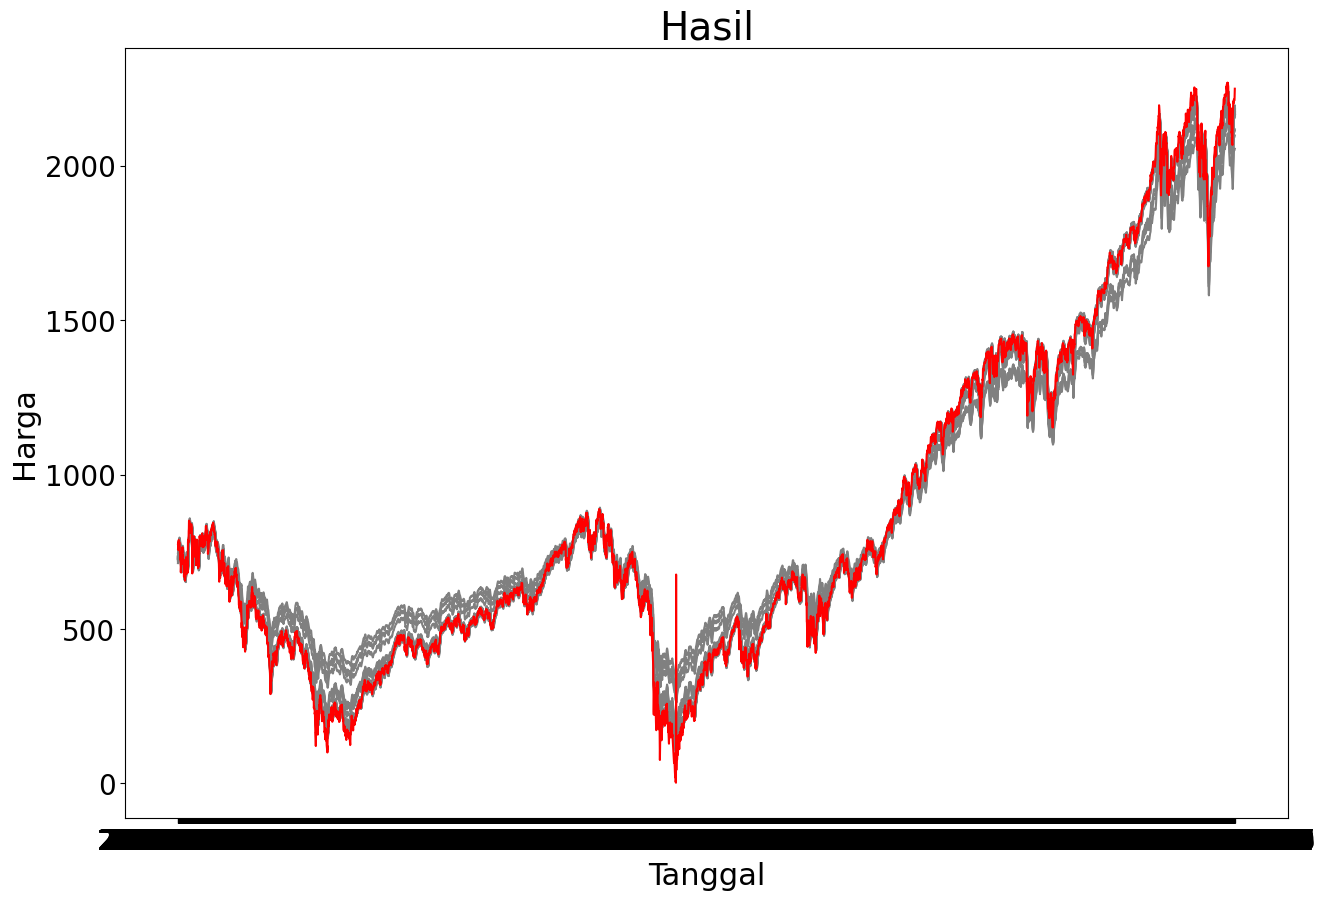

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in traincopy.columns:
  if column != 'Rata2':
    ax.plot(traincopy.index, traincopy[column], label='Prediksi', color='gray')
ax.plot(traincopy.index, y_train2, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

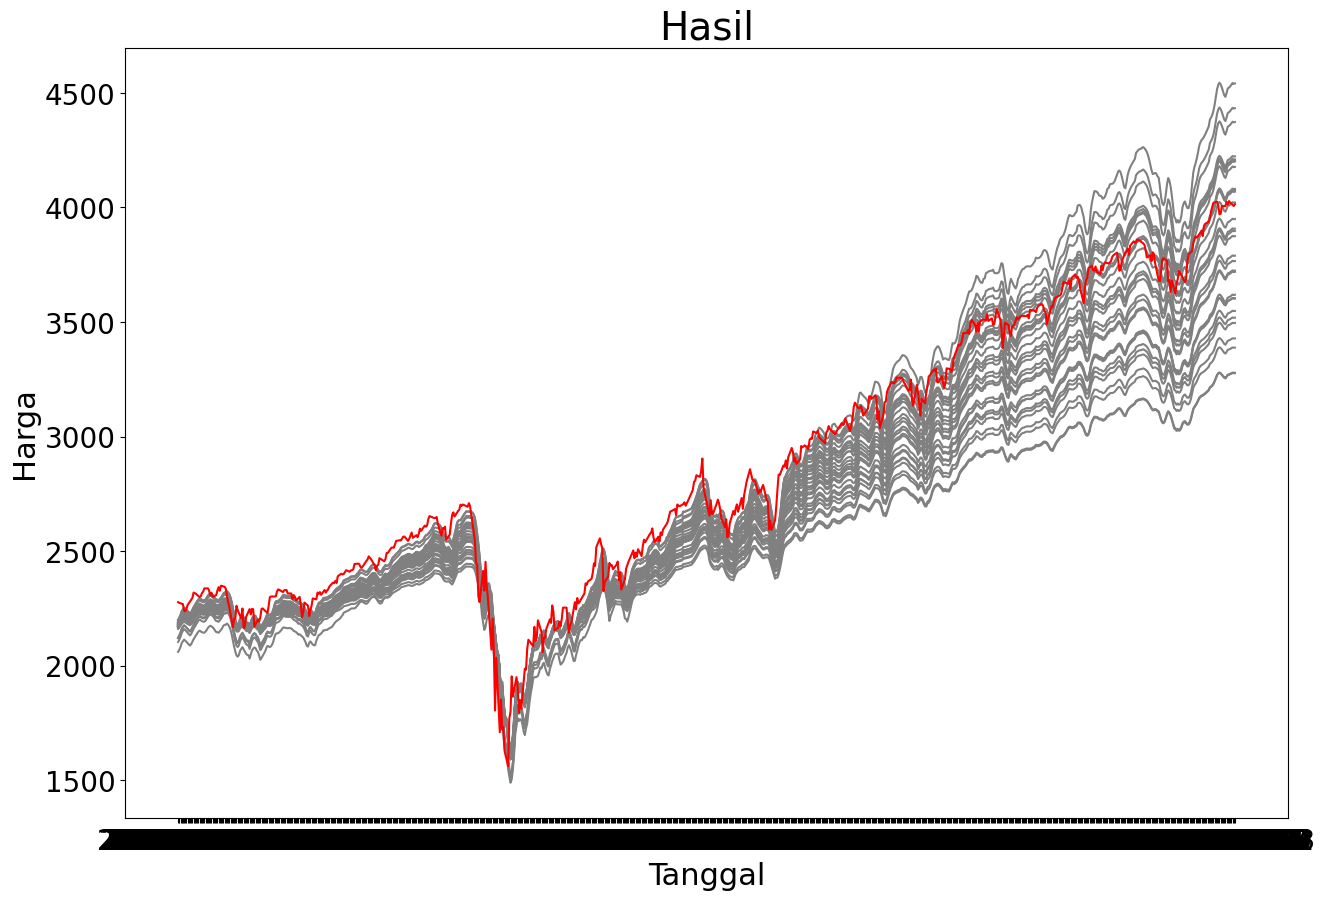

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in val_df.columns:
  if column != 'Rata2':
    ax.plot(val_df.index, val_df[column], label='Prediksi', color='gray')
ax.plot(val_df.index, y_val2, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

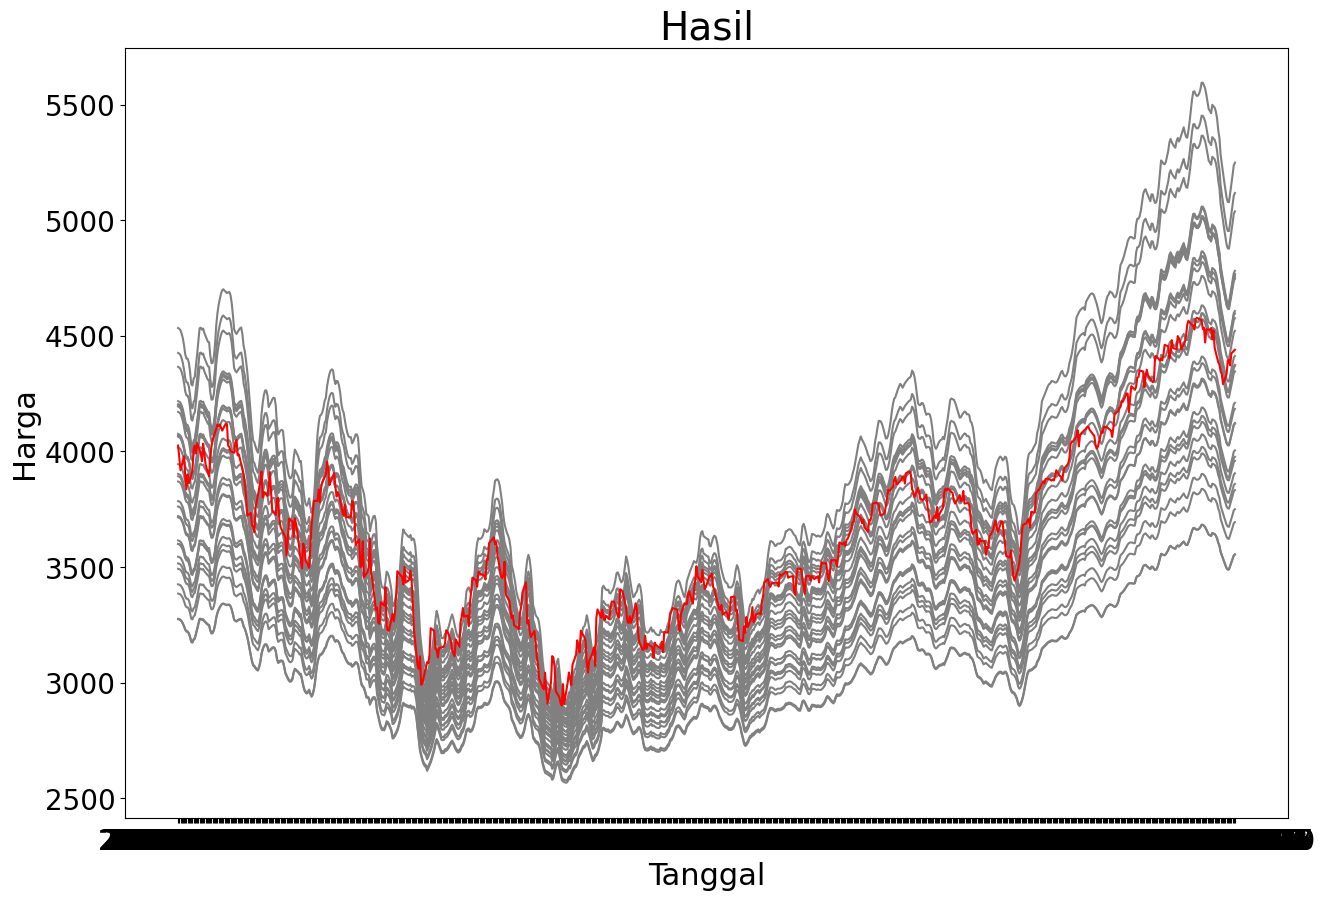

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in test_df.columns:
  if column != 'Rata2':
    ax.plot(test_df.index, test_df[column], label='Prediksi', color='gray')
ax.plot(test_df.index, y_test2, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## Model Hybrid

In [ ]:
traincnn = train_df['Rata2']
valcnn = val_df['Rata2']
testcnn = test_df['Rata2']

traincnn = pd.DataFrame(traincnn)
valcnn = pd.DataFrame(valcnn)
testcnn = pd.DataFrame(testcnn)

traincnn.columns = ['Close']
valcnn.columns = ['Close']
testcnn.columns = ['Close']

traincnn = traincnn.divide(range_value)
valcnn = valcnn.divide(range_value)
testcnn = testcnn.divide(range_value)
traincnn.shape, valcnn.shape, testcnn.shape, df.shape

((7102, 1), (888, 1), (888, 1), (8883, 6))

In [ ]:
padding = traincnn[:2]
df = pd.concat([padding, traincnn, valcnn, testcnn])
df.reset_index(drop=True, inplace=True)
df

Close
0     0.159735
1     0.161808
2     0.159735
3     0.161808
4     0.164424
...        ...
8875  0.926243
8876  0.931446
8877  0.937132
8878  0.943010
8879  0.944698

[8880 rows x 1 columns]

In [ ]:
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()
df['EMA_200']= df['Close'].ewm(span=200, adjust=False).mean()
df['Diff'] = df['EMA_50']-df['EMA_200']
df['sign'] = df['Diff'].apply(lambda x:1 if x>0 else (-1 if x<0 else 0))
df['sign_change'] = df['sign'].diff().apply(lambda x: 1 if x != 0 else 0)
idx1 = df[df['sign_change']==1]

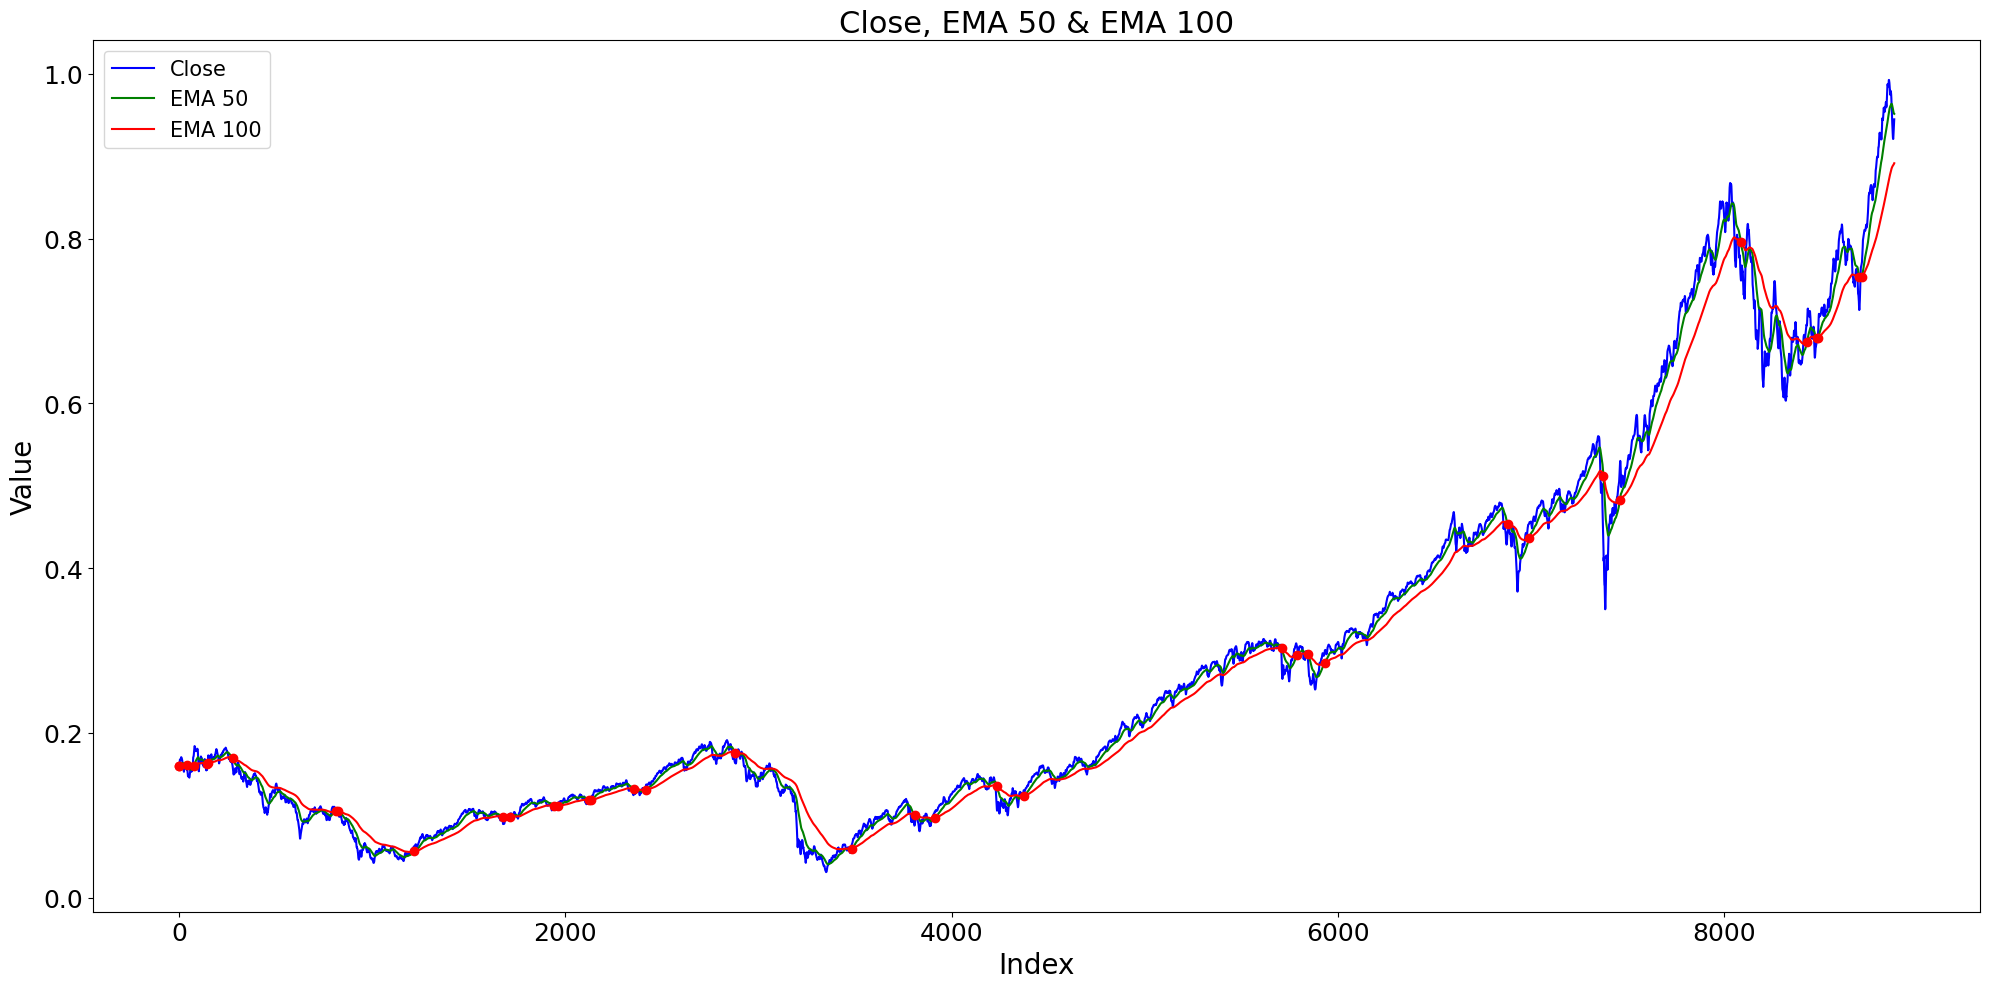

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
plt.plot(df['Close'], label='Close', color='blue')
plt.plot(df['EMA_50'], label='EMA50', color='green')
plt.plot(df['EMA_200'], label='EMA200', color='red')
plt.plot(idx1.index, df.loc[idx1.index, 'EMA_200'], 'ro', label='Sign Change')
plt.legend(['Close','EMA 50','EMA 100'], fontsize=15)
plt.title('Close, EMA 50 & EMA 100', fontsize=22)
plt.xlabel('Index', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

## Data Buy Keep Sell


In [ ]:
df['label'] = df.apply(
    lambda row: 'Buy' if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                ('Sell' if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 'Keep'),
    axis=1
)
df_buy_sell = df[df['label'] != 'Keep']
df_buy_sell

Close    EMA_50   EMA_200      Diff  sign  sign_change label
1     0.161808  0.159816  0.159755  0.000061     1            1  Sell
43    0.155508  0.160389  0.160398 -0.000009    -1            1   Buy
79    0.180285  0.159677  0.159346  0.000331     1            1  Sell
147   0.160528  0.162695  0.162738 -0.000042    -1            1   Buy
149   0.165592  0.162821  0.162769  0.000052     1            1  Sell
279   0.157581  0.169023  0.169233 -0.000209    -1            1   Buy
814   0.105626  0.104714  0.104712  0.000003     1            1  Sell
822   0.101728  0.104670  0.104708 -0.000038    -1            1   Buy
1218  0.062034  0.055958  0.055932  0.000025     1            1  Sell
1675  0.094120  0.098182  0.098235 -0.000053    -1            1   Buy
1714  0.101811  0.097646  0.097598  0.000049     1            1  Sell
1942  0.107670  0.111178  0.111219 -0.000040    -1            1   Buy
1964  0.115284  0.111229  0.111183  0.000047     1            1  Sell
2121  0.115945  0.117843  0.117892 -0.000049    -1            1   Buy
2132  0.121287  0.117983  0.117909  0.000074     1            1  Sell
2354  0.124645  0.131828  0.131882 -0.000054    -1            1   Buy
2418  0.136949  0.131134  0.131014  0.000120     1            1  Sell
2880  0.163165  0.175437  0.175781 -0.000343    -1            1   Buy
3486  0.066260  0.059458  0.059383  0.000076     1            1  Sell
3808  0.087457  0.099861  0.100062 -0.000202    -1            1   Buy
3914  0.104511  0.096877  0.096670  0.000207     1            1  Sell
4234  0.107231  0.134869  0.135521 -0.000652    -1            1   Buy
4376  0.129487  0.123889  0.123808  0.000081     1            1  Sell
5711  0.267003  0.301536  0.302564 -0.001027    -1            1   Buy
5787  0.305533  0.294344  0.294068  0.000277     1            1  Sell
5847  0.279887  0.295050  0.295429 -0.000379    -1            1   Buy
5930  0.297175  0.284686  0.284610  0.000076     1            1  Sell
6879  0.443654  0.453201  0.453393 -0.000191    -1            1   Buy
6991  0.455617  0.437022  0.436562  0.000460     1            1  Sell
7374  0.422833  0.510815  0.512002 -0.001187    -1            1   Buy
7460  0.529198  0.484178  0.482886  0.001292     1            1  Sell
8085  0.750431  0.795217  0.795934 -0.000717    -1            1   Buy
8429  0.702628  0.675411  0.674965  0.000446     1            1  Sell
8479  0.676991  0.679101  0.679128 -0.000027    -1            1   Buy
8485  0.685414  0.679187  0.679140  0.000048     1            1  Sell
8699  0.714554  0.752094  0.752882 -0.000789    -1            1   Buy
8711  0.770077  0.753241  0.752949  0.000292     1            1  Sell

In [ ]:
df['label1'] = df.apply(
    lambda row: 1 if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                (-1 if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 0),
    axis=1
)
df_buy_sell1 = df[df['label1'] != 0]
df_buy_sell1

Close    EMA_50   EMA_200      Diff  sign  sign_change label  label1
1     0.161808  0.159816  0.159755  0.000061     1            1  Sell      -1
43    0.155508  0.160389  0.160398 -0.000009    -1            1   Buy       1
79    0.180285  0.159677  0.159346  0.000331     1            1  Sell      -1
147   0.160528  0.162695  0.162738 -0.000042    -1            1   Buy       1
149   0.165592  0.162821  0.162769  0.000052     1            1  Sell      -1
279   0.157581  0.169023  0.169233 -0.000209    -1            1   Buy       1
814   0.105626  0.104714  0.104712  0.000003     1            1  Sell      -1
822   0.101728  0.104670  0.104708 -0.000038    -1            1   Buy       1
1218  0.062034  0.055958  0.055932  0.000025     1            1  Sell      -1
1675  0.094120  0.098182  0.098235 -0.000053    -1            1   Buy       1
1714  0.101811  0.097646  0.097598  0.000049     1            1  Sell      -1
1942  0.107670  0.111178  0.111219 -0.000040    -1            1   Buy       1
1964  0.115284  0.111229  0.111183  0.000047     1            1  Sell      -1
2121  0.115945  0.117843  0.117892 -0.000049    -1            1   Buy       1
2132  0.121287  0.117983  0.117909  0.000074     1            1  Sell      -1
2354  0.124645  0.131828  0.131882 -0.000054    -1            1   Buy       1
2418  0.136949  0.131134  0.131014  0.000120     1            1  Sell      -1
2880  0.163165  0.175437  0.175781 -0.000343    -1            1   Buy       1
3486  0.066260  0.059458  0.059383  0.000076     1            1  Sell      -1
3808  0.087457  0.099861  0.100062 -0.000202    -1            1   Buy       1
3914  0.104511  0.096877  0.096670  0.000207     1            1  Sell      -1
4234  0.107231  0.134869  0.135521 -0.000652    -1            1   Buy       1
4376  0.129487  0.123889  0.123808  0.000081     1            1  Sell      -1
5711  0.267003  0.301536  0.302564 -0.001027    -1            1   Buy       1
5787  0.305533  0.294344  0.294068  0.000277     1            1  Sell      -1
5847  0.279887  0.295050  0.295429 -0.000379    -1            1   Buy       1
5930  0.297175  0.284686  0.284610  0.000076     1            1  Sell      -1
6879  0.443654  0.453201  0.453393 -0.000191    -1            1   Buy       1
6991  0.455617  0.437022  0.436562  0.000460     1            1  Sell      -1
7374  0.422833  0.510815  0.512002 -0.001187    -1            1   Buy       1
7460  0.529198  0.484178  0.482886  0.001292     1            1  Sell      -1
8085  0.750431  0.795217  0.795934 -0.000717    -1            1   Buy       1
8429  0.702628  0.675411  0.674965  0.000446     1            1  Sell      -1
8479  0.676991  0.679101  0.679128 -0.000027    -1            1   Buy       1
8485  0.685414  0.679187  0.679140  0.000048     1            1  Sell      -1
8699  0.714554  0.752094  0.752882 -0.000789    -1            1   Buy       1
8711  0.770077  0.753241  0.752949  0.000292     1            1  Sell      -1

In [ ]:
datacnn = df.copy()
datacnn = df[['Close','label1']]
datacnn

Close  label1
0     0.159735       0
1     0.161808      -1
2     0.159735       0
3     0.161808       0
4     0.164424       0
...        ...     ...
8875  0.926243       0
8876  0.931446       0
8877  0.937132       0
8878  0.943010       0
8879  0.944698       0

[8880 rows x 2 columns]

In [ ]:
def windowed_df_close(data, n):
    dates = []
    data_as_np = data.to_numpy()
    l = data.shape[0]
    dates = []
    X, Y = [], []
    for i in range(n, l):
        indexes = data.index[i-n:i+1]
        row = [r for r in data_as_np[i-n:i]]
        X.append(row)
        y = data_as_np[i][0]
        Y.append(y)
        dates.append(indexes[-1])
    return np.array(X), np.array(Y), np.array(dates)

X_pred, y_pred, dates_pred = windowed_df_close(datacnn, 2)
n_total2 = len(X_pred)
Mq_80 = int(n_total2*0.8)
Mq_90 = int(n_total2*0.9)
dates_pred_train, X_pred_train, y_pred_train = dates_pred[:Mq_80], X_pred[:Mq_80], y_pred[:Mq_80]
dates_pred_val, X_pred_val, y_pred_val = dates_pred[Mq_80:Mq_90],  X_pred[Mq_80:Mq_90], y_pred[Mq_80:Mq_90]
dates_pred_test, X_pred_test, y_pred_test = dates_pred[Mq_90:],  X_pred[Mq_90:], y_pred[Mq_90:]

In [ ]:
datacnn

Close  label1
0     0.159735       0
1     0.161808      -1
2     0.159735       0
3     0.161808       0
4     0.164424       0
...        ...     ...
8875  0.926243       0
8876  0.931446       0
8877  0.937132       0
8878  0.943010       0
8879  0.944698       0

[8880 rows x 2 columns]

In [ ]:
X_pred_train.shape, X_pred_val.shape, X_pred_test.shape, y_pred_test.shape

((7102, 2, 2), (888, 2, 2), (888, 2, 2), (888,))

In [ ]:
datafull2 = data_full.copy()
datafull2.index = datafull2['Date']
datafull2 = data_full['Close']
datafull2 = datafull2[3:]
datafull2 = datafull2.rename(columns={'^SPX': 'Close'})

datafull2['EMA_50'] = datafull2['Close'].ewm(span=50, adjust=False).mean()
datafull2['EMA_200']= datafull2['Close'].ewm(span=200, adjust=False).mean()
datafull2['Diff'] = datafull2['EMA_50']-datafull2['EMA_200']
datafull2['sign'] = datafull2['Diff'].apply(lambda x:1 if x>0 else (-1 if x<0 else 0))
datafull2['sign_change'] = datafull2['sign'].diff().apply(lambda x: 1 if x != 0 else 0)
idx1 = datafull2[datafull2['sign_change']==1]
datafull2['label'] = datafull2.apply(
    lambda row: 'Buy' if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                ('Sell' if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 'Keep'),
    axis=1
)
datafull2_buy_sell = datafull2[datafull2['label'] != 'Keep']
datafull2['label1'] = datafull2.apply(
    lambda row: 1 if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                (-1 if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 0),
    axis=1
)
datafull2_buy_sell1 = datafull2[datafull2['label1'] != 0]

datafull2 = datafull2[['Close', 'label1']]
datafull2['Close'] = pd.to_numeric(datafull2['Close'])
datafull2['label1'] = pd.to_numeric(datafull2['label1'])

X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
datafull2

Ticker         Close  label1
Date                        
2000-01-07  0.167097       0
2000-01-08  0.168271      -1
2000-01-09  0.169446       0
2000-01-10  0.170620       0
2000-01-11  0.166461       0
...              ...     ...
2024-04-25  0.955016       0
2024-04-26  0.966274       0
2024-04-27  0.967455       0
2024-04-28  0.968635       0
2024-04-29  0.969815       0

[8880 rows x 2 columns]

## CNN HYPERPARAMETER TUNING

In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

def build_cnn_model(hp):
    model = Sequential()

    model.add(Conv1D(
        filters=hp.Choice('filters', values=[8, 16, 32, 64]),
        kernel_size=2,
        activation=hp.Choice('activation_conv', values=['relu', 'tanh']),
        padding="same",
        input_shape=(2, 2)
    ))

    model.add(Flatten())

    model.add(Dense(
        units=hp.Choice('dense_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_dense', values=['relu', 'tanh'])
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

tuner = kt.RandomSearch(
    build_cnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='random_search_cnn',
    project_name='cnn_tuning_activation'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

tuner.search(
    X_pred_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Menampilkan hasil terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Filters: {best_hps.get('filters')}
- Activation (Conv1D): {best_hps.get('activation_conv')}
- Dense Layer Units: {best_hps.get('dense_units')}
- Activation (Dense): {best_hps.get('activation_dense')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 60 Complete [00h 00m 39s]
val_loss: 0.0008268247474916279

Best val_loss So Far: 0.00022569744032807648
Total elapsed time: 00h 36m 17s

Best Hyperparameters:
- Filters: 8
- Activation (Conv1D): relu
- Dense Layer Units: 64
- Activation (Dense): tanh
- Dropout: 0.3
- Learning Rate: 0.01



In [ ]:
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters as hp

def build_cnn_model(hp):
    model = Sequential()
    model.add(Reshape((2, 2), input_shape=(2, 2)))
    model.add(Conv1D(
        filters=hp.Choice('filters', values=[8, 16, 32, 64]),
        kernel_size=2,
        activation=hp.Choice('activation_conv', values=['relu', 'tanh']),
        padding="same"
    ))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Choice('dense_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_dense', values=['relu', 'tanh'])
    ))
    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))
    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model


bayesian_opt_tuner = BayesianOptimization(
    build_cnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='bayesian cnn',
    project_name='kerastuner_bayesian_cnn',
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

bayesian_opt_tuner.search(
    X_pred_train, y_train,
    epochs=150,
    validation_data=(X_pred_val, y_val),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

best_cnn_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_cnn_models[0]

Trial 60 Complete [00h 00m 33s]
val_loss: 0.00025094073498621583

Best val_loss So Far: 0.00025094073498621583
Total elapsed time: 00h 39m 12s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_trial = bayesian_opt_tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values
print("Best Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

best_cnn_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_cnn_models[0]

Best Hyperparameters:
filters: 8
activation_conv: relu
dense_units: 128
activation_dense: tanh
dropout: 0.3
learning_rate: 0.01


## CNN MODEL

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datacnn, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

cnn = Sequential()
cnn.add(Reshape((2, 2), input_shape=(2, 2)))
cnn.add(Conv1D(8, kernel_size=2, activation="relu", padding="same"))
cnn.add(Flatten())
cnn.add(Dense(64, activation="tanh"))
cnn.add(Dropout(0.3))
cnn.add(Dense(1, activation="linear"))

cnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 2, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 8)           │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,193 (4.66 KB)

 Trainable params: 1,193 (4.66 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("cnnrs_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(cnn)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"cnnrs_weights/best_cnnrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")


 Model di iterasi ke-21 dengan MAPE = 0.0223


In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.890737   0.894415   0.881442   0.886072   0.890607   0.881567   
2021-11-25   0.890033   0.893529   0.880273   0.885203   0.889954   0.880373   
2021-11-26   0.889279   0.892870   0.879782   0.884567   0.889187   0.879878   
2021-11-27   0.888465   0.892007   0.878855   0.883727   0.888395   0.878935   
2021-11-28   0.886586   0.889966   0.876586   0.881736   0.886576   0.876624   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.971056   0.973941   0.958775   0.962988   0.970113   0.959495   
2024-04-26   0.974763   0.978349   0.964780   0.967266   0.973614   0.965079   
2024-04-27   0.980268   0.983781   0.970044   0.972495   0.979068   0.970368   
2024-04-28   0.986041   0.989568   0.975861   0.978066   0.984767   0.976159   
2024-04-29   0.992114   0.995613   0.981837   0.983879   0.990772   0.982135   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDO.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDO.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDO.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnrs_INDO.csv')
#bm_train_predictions.to_csv('hasilprediksicnnrs_train_INDO.csv')
#bm_val_predictions.to_csv('hasilprediksicnnrs_val_INDO.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksicnnrs_INDO.csv')
bm_train_predictions.to_csv('hasilprediksicnnrs_train_INDO.csv')
bm_val_predictions.to_csv('hasilprediksicnnrs_val_INDO.csv')


In [ ]:
!zip -r cnnrs_weights.zip /content/cnnrs_weights
from google.colab import files
files.download("cnnrs_weights.zip")

  adding: content/cnnrs_weights/ (stored 0%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_16.weights.h5 (deflated 62%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_2.weights.h5 (deflated 62%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_18.weights.h5 (deflated 62%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_27.weights.h5 (deflated 63%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_13.weights.h5 (deflated 63%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_22.weights.h5 (deflated 62%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_26.weights.h5 (deflated 62%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_12.weights.h5 (deflated 63%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_19.weights.h5 (deflated 62%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_30.weights.h5 (deflated 63%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_28.weights.h5 (deflated 64%)
  adding: content/cnn

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

25.651406893223903 1249.2673837372415 35.34497678224222 68652252212679.39
51.39850371306368 5290.340439270968 72.73472650165785 0.01955507898235552
75.24710394598699 8911.640505586924 94.4014857170528 0.020689042175197802


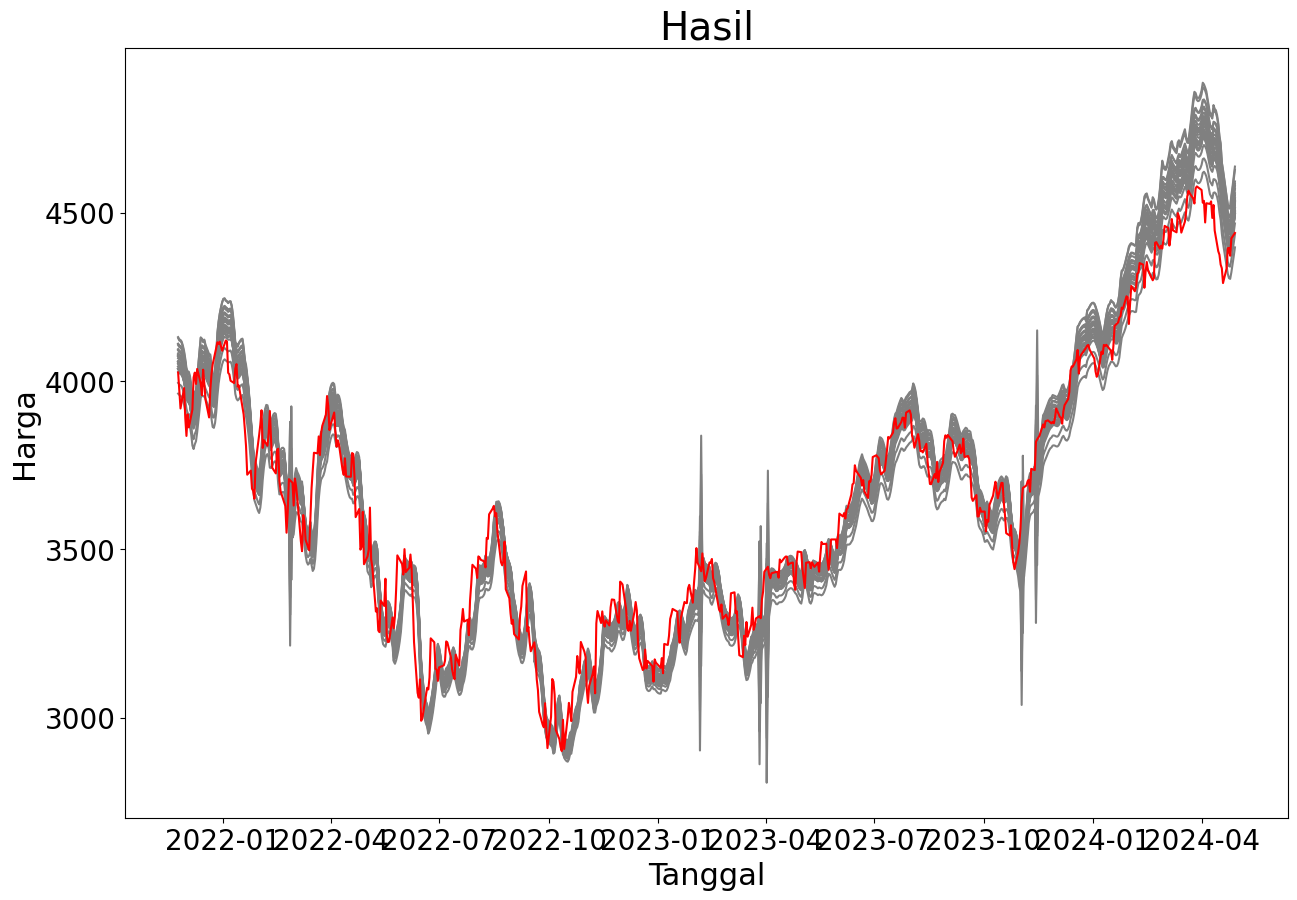

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

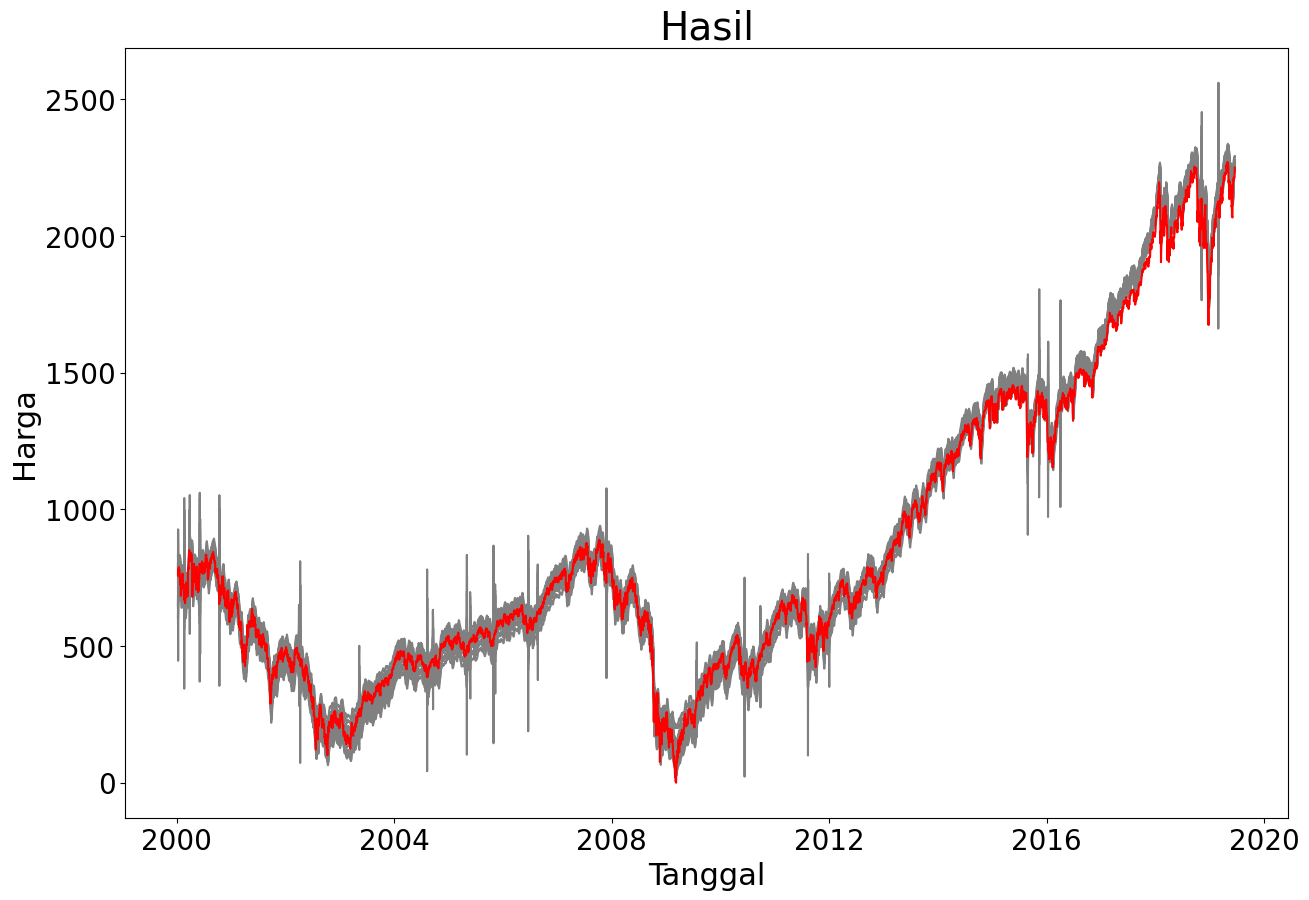

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## CNN dengan Bayesian

In [ ]:
X_pred, y_pred, dates_pred = windowed_df_close(datacnn, 2)
n_total2 = len(X_pred)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_pred_train, X_pred_train, y_pred_train = dates_pred[:Mqn_80], X_pred[:Mqn_80], y_pred[:Mqn_80]
dates_pred_val, X_pred_val, y_pred_val = dates_pred[Mqn_80:Mqn_90],  X_pred[Mqn_80:Mqn_90], y_pred[Mqn_80:Mqn_90]
dates_pred_test, X_pred_test, y_pred_test = dates_pred[Mqn_90:],  X_pred[Mqn_90:], y_pred[Mqn_90:]
print(X_pred_train.shape, X_pred_val.shape, X_pred_test.shape, y_pred_test.shape)
print(y_pred_train.shape, y_pred_val.shape, y_pred_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
cnn = Sequential()
cnn.add(Reshape((2, 2), input_shape=(2, 2)))
cnn.add(Conv1D(8, kernel_size=2, activation="relu", padding="same"))
cnn.add(Flatten())
cnn.add(Dense(128, activation="tanh"))
cnn.add(Dropout(0.3))
cnn.add(Dense(1, activation="linear"))

cnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 2, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 2, 8)           │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,345 (9.16 KB)

 Trainable params: 2,345 (9.16 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("cnnbo_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(cnn)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"cnnbo_weights/best_cnnrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")


 Model di iterasi ke-10 dengan MAPE = 0.0209


In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.891511   0.889850   0.880024   0.893569   0.888988   0.886124   
2021-11-25   0.890810   0.889076   0.879250   0.892905   0.888013   0.884890   
2021-11-26   0.890053   0.888363   0.878566   0.892136   0.887393   0.884395   
2021-11-27   0.889239   0.887533   0.877752   0.891336   0.886503   0.883429   
2021-11-28   0.887362   0.885596   0.875848   0.889499   0.884376   0.881060   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.972034   0.969733   0.957646   0.973774   0.968737   0.965534   
2024-04-26   0.975738   0.973727   0.961605   0.977335   0.973504   0.971309   
2024-04-27   0.981264   0.979211   0.966925   0.982850   0.978951   0.976707   
2024-04-28   0.987058   0.985000   0.972551   0.988616   0.984798   0.982627   
2024-04-29   0.993155   0.991075   0.978447   0.994693   0.990886   0.988734   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDO.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDO.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDO.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

bm_prediction_df.to_csv('hasilprediksicnnbo_INDO.csv')
bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDO.csv')
bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDO.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksicnnbo_INDO.csv')
bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDO.csv')
bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDO.csv')


In [ ]:
!zip -r cnnbo_weights.zip /content/cnnbo_weights
from google.colab import files
files.download("cnnbo_weights.zip")

  adding: content/cnnbo_weights/ (stored 0%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_16.weights.h5 (deflated 49%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_2.weights.h5 (deflated 48%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_18.weights.h5 (deflated 48%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_27.weights.h5 (deflated 48%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_13.weights.h5 (deflated 50%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_22.weights.h5 (deflated 48%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_26.weights.h5 (deflated 48%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_12.weights.h5 (deflated 48%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_19.weights.h5 (deflated 48%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_30.weights.h5 (deflated 48%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_28.weights.h5 (deflated 48%)
  adding: content/cnn

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

26.60424965819337 1303.602778653011 36.1054397377045 63471454866557.49
50.68640627016179 5280.223622230345 72.66514723187689 0.01940749289590295
77.61895220415727 9568.47290999765 97.81857139622133 0.02121799411907602


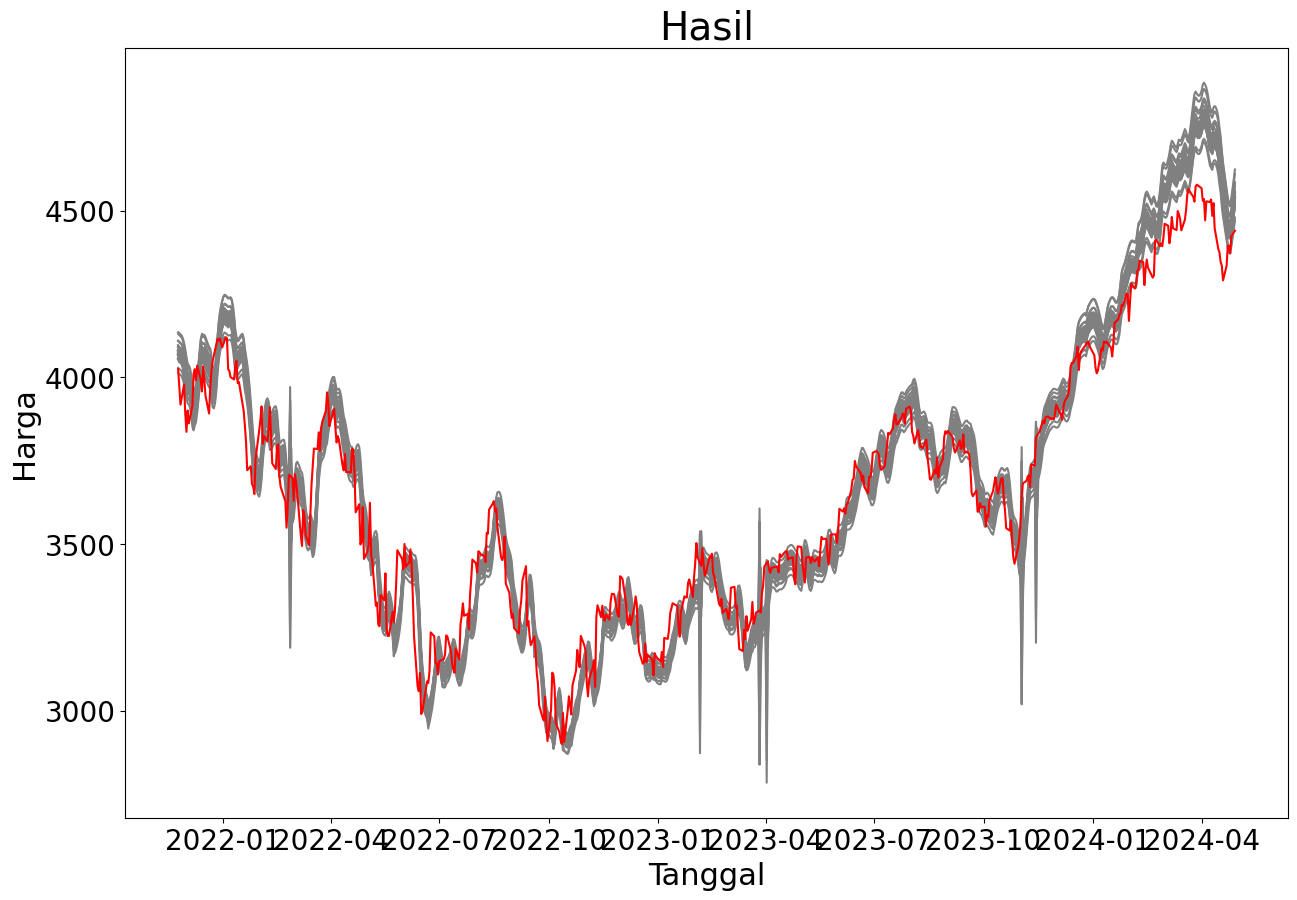

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

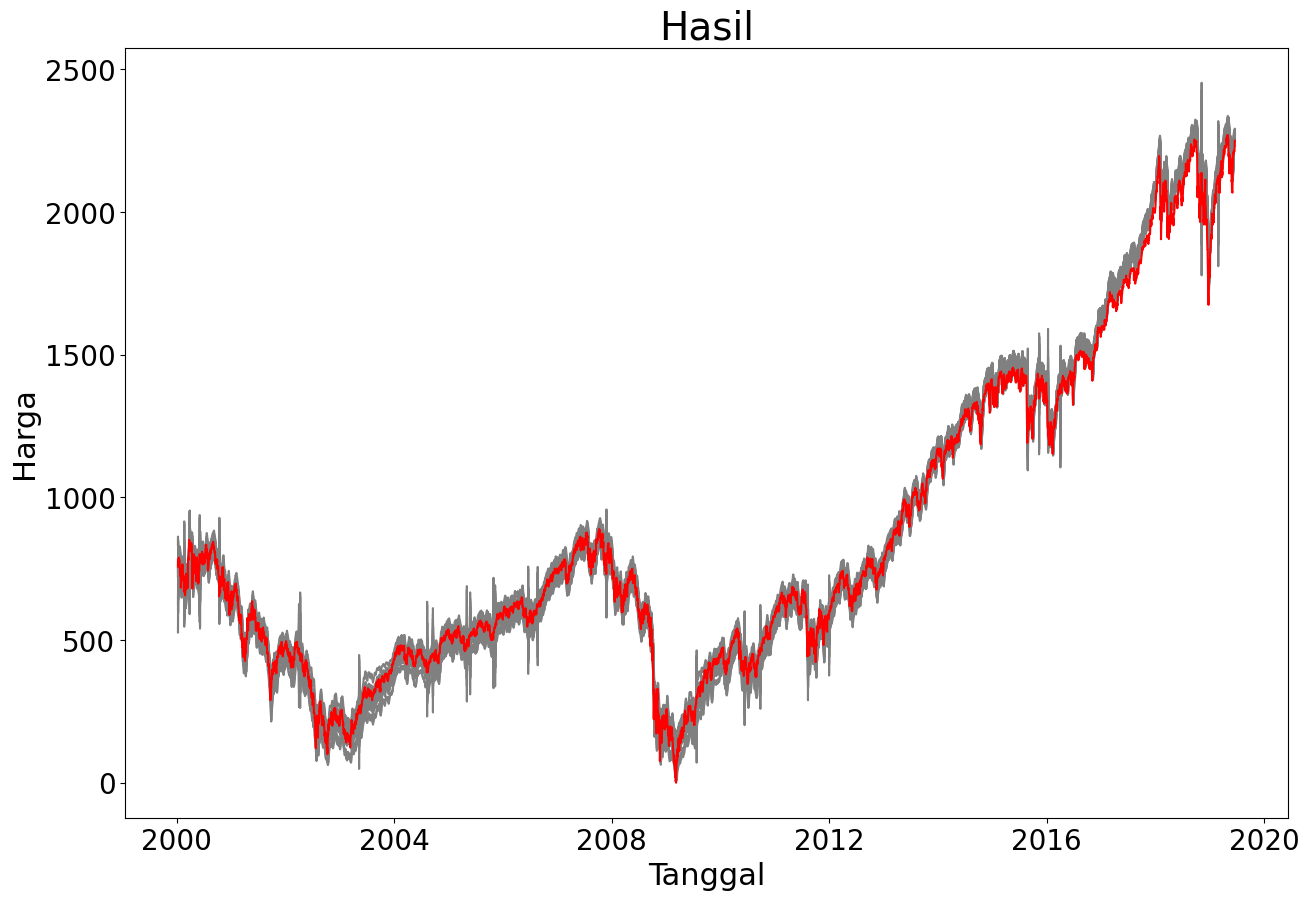

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## ANN

In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

def build_ann_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(2,2)))

    model.add(Dense(
        units=hp.Choice('dense_units_1', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid'])
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
        ),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

tuner = kt.RandomSearch(
    build_ann_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='random_search_ann',
    project_name='ann_tuning'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

tuner.search(
    X_pred_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Dense Layer 1 Units: {best_hps.get('dense_units_1')}
- Activation 1: {best_hps.get('activation_1')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 60 Complete [00h 01m 14s]
val_loss: 0.011449412442743778

Best val_loss So Far: 0.00023591799254063517
Total elapsed time: 00h 47m 12s

Best Hyperparameters:
- Dense Layer 1 Units: 32
- Activation 1: sigmoid
- Dropout: 0.1
- Learning Rate: 0.01



In [ ]:
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters as hp
def build_ann_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(2, 2)))

    model.add(Dense(
        units=hp.Choice('dense_units_1', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid'])
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
        ),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

bayesian_opt_tuner = kt.BayesianOptimization(
    build_ann_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

bayesian_opt_tuner.search(
    X_pred_train, y_train,
    epochs=150,
    validation_data=(X_pred_val, y_val),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

best_ann_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_ann_models[0]

print("\n--- Best Model Summary ---")
model.summary()

best_trial = bayesian_opt_tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values
print("\nBest Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Trial 60 Complete [00h 00m 24s]
val_loss: 0.00027435136144049466

Best val_loss So Far: 0.0002575656690169126
Total elapsed time: 00h 38m 17s

--- Best Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385 (1.50 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)


Best Hyperparameters:
dense_units_1: 64
activation_1: tanh
dropout: 0.2
learning_rate: 0.01


In [ ]:
ann = Sequential()
ann.add(Flatten(input_shape=(2,2)))
ann.add(Dense(32, activation='sigmoid'))
ann.add(Dropout(0.1))
ann.add(Dense(1, activation='linear'))

ann.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

ann.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("annrs_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(ann)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"annrs_weights/best_annrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")


 Model di iterasi ke-24 dengan MAPE = 0.0224


In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.876245   0.864034   0.866162   0.860141   0.862535   0.763055   
2021-11-25   0.875916   0.863708   0.865843   0.859843   0.862237   0.762948   
2021-11-26   0.875324   0.863170   0.865323   0.859349   0.861702   0.762763   
2021-11-27   0.874808   0.862686   0.864853   0.858904   0.861235   0.762599   
2021-11-28   0.873654   0.861597   0.863792   0.857903   0.860189   0.762230   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.924886   0.908663   0.908543   0.900335   0.906121   0.777186   
2024-04-26   0.926364   0.910069   0.909857   0.901573   0.907437   0.777596   
2024-04-27   0.929201   0.912652   0.912246   0.903843   0.909964   0.778356   
2024-04-28   0.932060   0.915259   0.914651   0.906127   0.912510   0.779118   
2024-04-29   0.935023   0.917958   0.917131   0.908485   0.915149   0.779902   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDO.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDO.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDO.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_INDO.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDO.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDO.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksiannrs_INDO.csv')
bm_train_predictions.to_csv('hasilprediksiannrs_train_INDO.csv')
bm_val_predictions.to_csv('hasilprediksiannrs_val_INDO.csv')


In [ ]:
!zip -r annrs_weights.zip /content/annrs_weights
from google.colab import files
files.download("annrs_weights.zip")

  adding: content/annrs_weights/ (stored 0%)
  adding: content/annrs_weights/best_annrs_weights_iter_1.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_16.weights.h5 (deflated 85%)
  adding: content/annrs_weights/best_annrs_weights_iter_3.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_29.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_11.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_12.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_26.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_28.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_27.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_7.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_23.weights.h5 (deflated 86%)
  adding: content/annrs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

23.94472309838748 1011.8719075339664 31.809934101377298 22745573492238.324
73.82866909267676 9658.049430499192 98.27537550423907 0.02544721516243532
146.65241028381914 34073.22217021717 184.58933384737367 0.038179184366548914


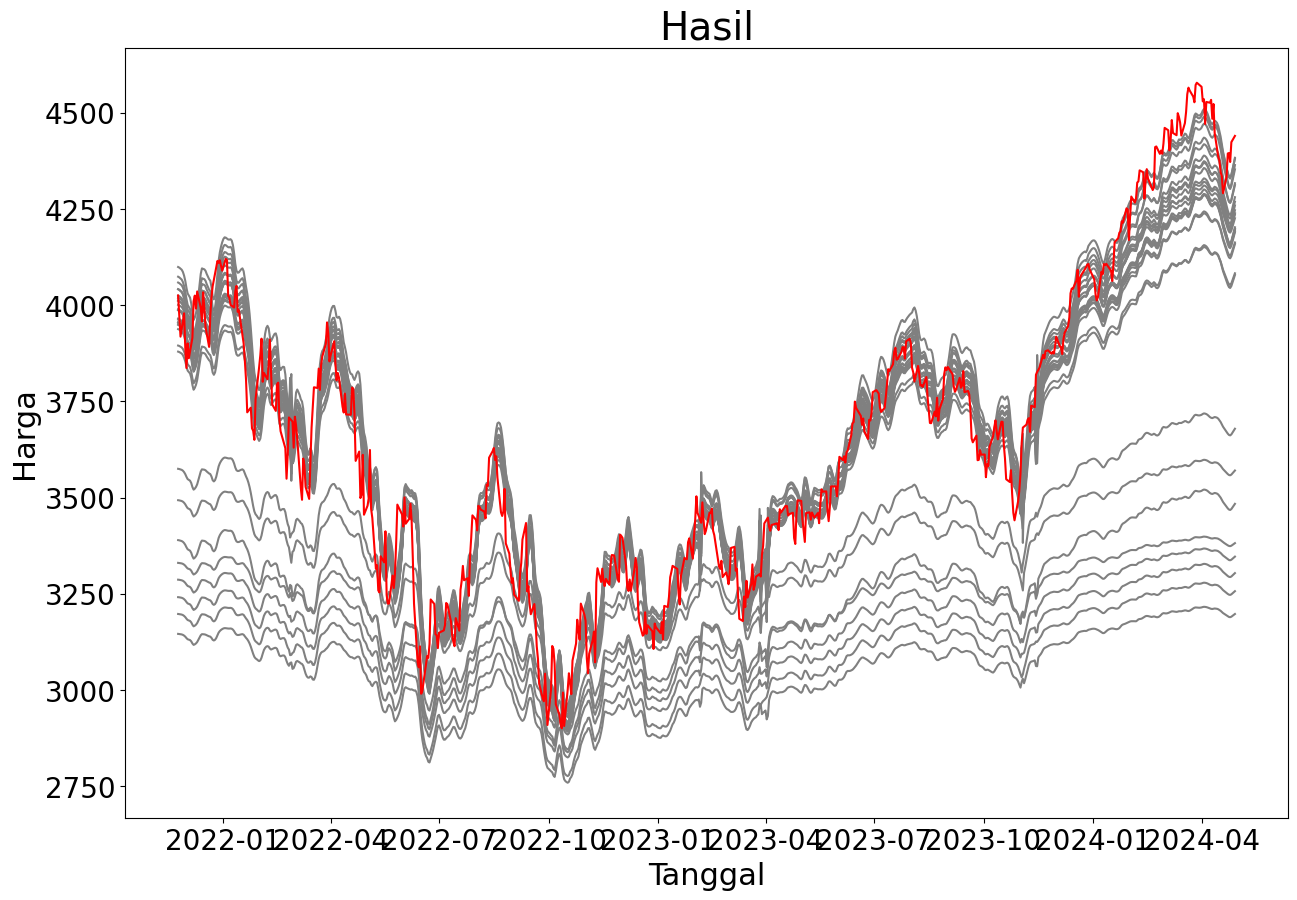

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

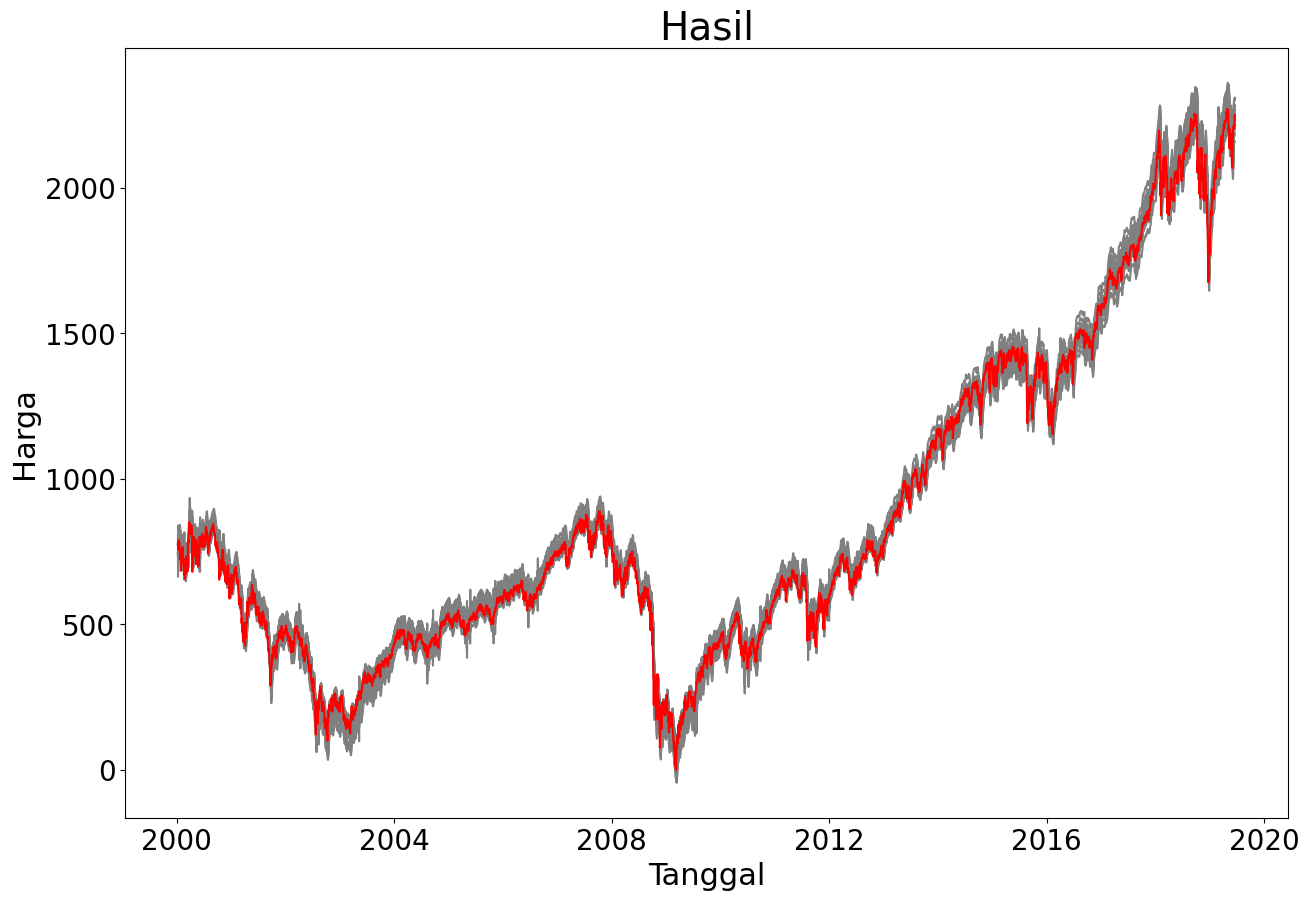

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## ANN dengan Bayesian

In [ ]:
ann = Sequential()
ann.add(Flatten(input_shape=(2,2)))
ann.add(Dense(64, activation='tanh'))
ann.add(Dropout(0.2))
ann.add(Dense(1, activation='linear'))

ann.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

ann.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385 (1.50 KB)

 Trainable params: 385 (1.50 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("annbo_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(ann)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"annbo_weights/best_annbo_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")


 Model di iterasi ke-15 dengan MAPE = 0.0225


In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.889531   0.887233   0.887330   0.882061   0.888532   0.890763   
2021-11-25   0.888964   0.886651   0.886743   0.881526   0.887971   0.890278   
2021-11-26   0.888174   0.885885   0.885973   0.880731   0.887193   0.889447   
2021-11-27   0.887416   0.885132   0.885215   0.879989   0.886446   0.888713   
2021-11-28   0.885695   0.883417   0.883489   0.878311   0.884751   0.887069   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.967706   0.964093   0.964772   0.959406   0.965437   0.969211   
2024-04-26   0.970847   0.967271   0.967983   0.962414   0.968534   0.972043   
2024-04-27   0.976203   0.972532   0.973292   0.967716   0.973798   0.977436   
2024-04-28   0.981762   0.978003   0.978816   0.973206   0.979263   0.982995   
2024-04-29   0.987634   0.983775   0.984645   0.979010   0.985033   0.988887   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDO.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDO.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDO.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_INDO.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDO.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDO.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksiannbo_INDO.csv')
bm_train_predictions.to_csv('hasilprediksiannbo_train_INDO.csv')
bm_val_predictions.to_csv('hasilprediksiannbo_val_INDO.csv')


In [ ]:
!zip -r annbo_weights.zip /content/annbo_weights
from google.colab import files
files.download("annbo_weights.zip")

  adding: content/annbo_weights/ (stored 0%)
  adding: content/annbo_weights/best_annbo_weights_iter_20.weights.h5 (deflated 79%)
  adding: content/annbo_weights/best_annbo_weights_iter_29.weights.h5 (deflated 79%)
  adding: content/annbo_weights/best_annbo_weights_iter_8.weights.h5 (deflated 79%)
  adding: content/annbo_weights/best_annbo_weights_iter_17.weights.h5 (deflated 79%)
  adding: content/annbo_weights/best_annbo_weights_iter_19.weights.h5 (deflated 79%)
  adding: content/annbo_weights/best_annbo_weights_iter_5.weights.h5 (deflated 79%)
  adding: content/annbo_weights/best_annbo_weights_iter_24.weights.h5 (deflated 79%)
  adding: content/annbo_weights/best_annbo_weights_iter_27.weights.h5 (deflated 79%)
  adding: content/annbo_weights/best_annbo_weights_iter_14.weights.h5 (deflated 79%)
  adding: content/annbo_weights/best_annbo_weights_iter_18.weights.h5 (deflated 79%)
  adding: content/annbo_weights/best_annbo_weights_iter_22.weights.h5 (deflated 79%)
  adding: content/annb

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

28.58917628805435 1437.3035008232816 37.911785777292025 56007471774226.086
52.01497991521797 5576.13301271639 74.67350944422252 0.01996655844474424
74.49900895768813 8805.583318737497 93.8380696665138 0.020538201172216535


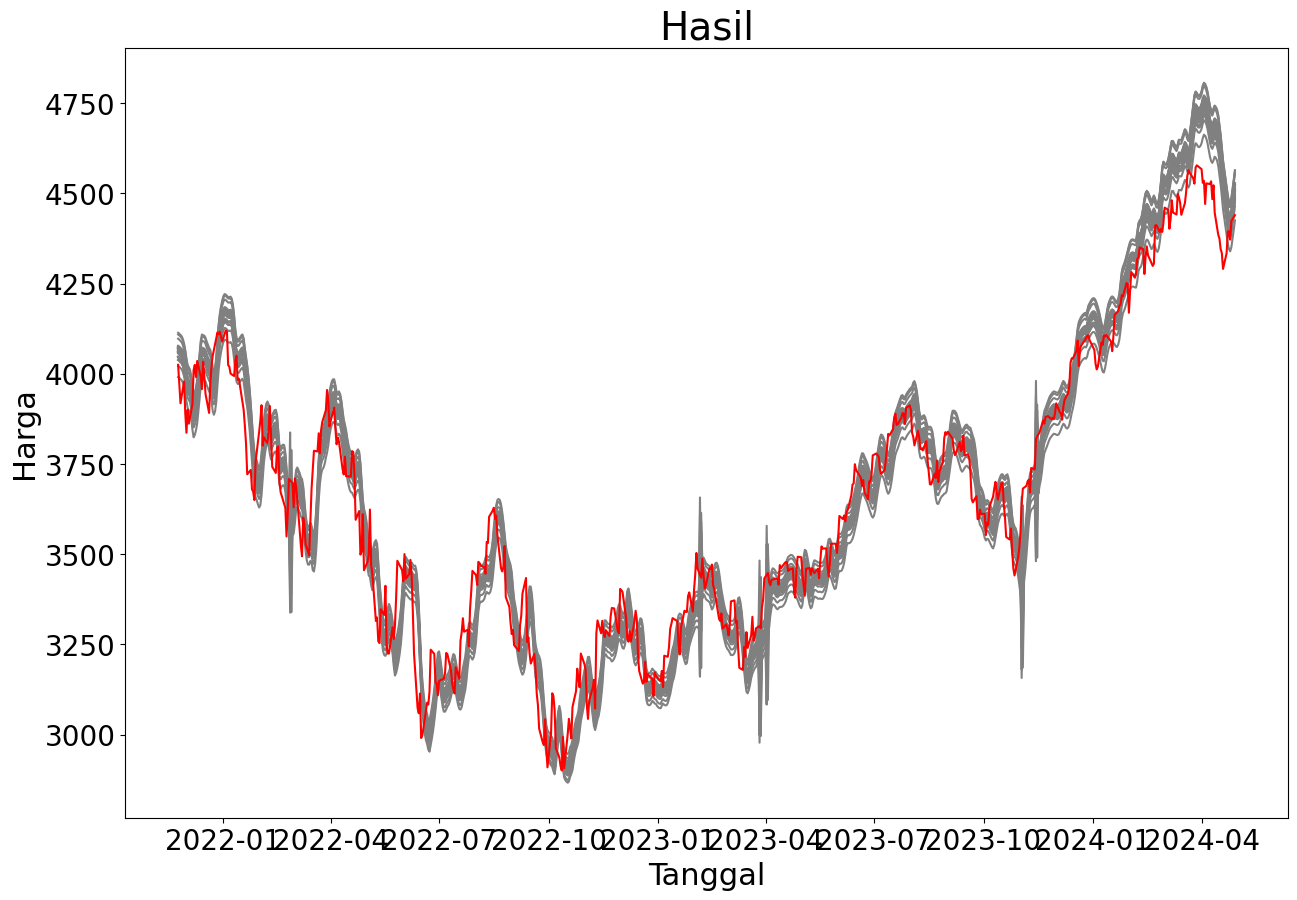

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

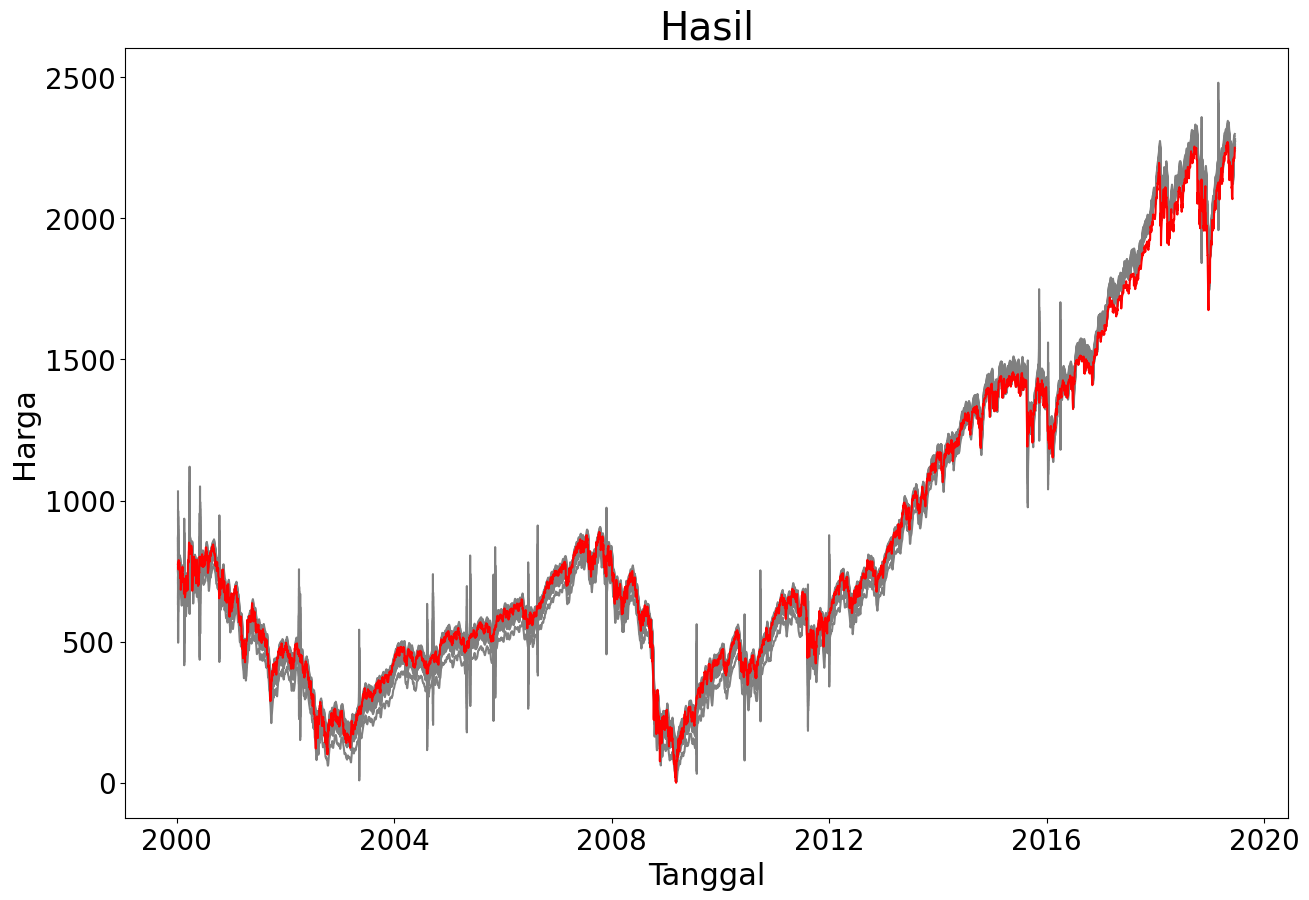

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## RNN

In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import SimpleRNN
def build_rnn_model(hp):
    model = Sequential()
    model.add(SimpleRNN(
        units=hp.Choice('rnn_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_shape=(2, 2),
        return_sequences=False
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

tuner = kt.RandomSearch(
    build_rnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='random_search_rnn',
    project_name='rnn_tuning'
)

tuner.search(
    X_pred_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- RNN Units: {best_hps.get('rnn_units')}
- Activation: {best_hps.get('activation')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 60 Complete [00h 00m 30s]
val_loss: 0.00026950243045575917

Best val_loss So Far: 0.00022957725741434842
Total elapsed time: 00h 56m 47s

Best Hyperparameters:
- RNN Units: 32
- Activation: sigmoid
- Dropout: 0.1
- Learning Rate: 0.01



In [ ]:
def build_rnn_model(hp):
    model = Sequential()
    model.add(SimpleRNN(
        units=hp.Choice('rnn_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_shape=(2, 2),
        return_sequences=False
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

bayesian_opt_tuner = kt.BayesianOptimization(
    build_rnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

bayesian_opt_tuner.search(
    X_pred_train, y_train,
    epochs=150,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)
best_rnn_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_rnn_models[0]

print("\n--- Best Model Summary ---")
model.summary()

best_trial = bayesian_opt_tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values
print("\nBest Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Trial 60 Complete [00h 00m 42s]
val_loss: 0.00037775098462589085

Best val_loss So Far: 0.00026889299624599516
Total elapsed time: 00h 39m 27s

--- Best Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)


Best Hyperparameters:
rnn_units: 64
activation: relu
dropout: 0.3
learning_rate: 0.01


In [ ]:
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
rnn = Sequential()
rnn.add(SimpleRNN(32, activation='sigmoid', input_shape=(2, 2), return_sequences=False))
rnn.add(Dropout(0.1))
rnn.add(Dense(1))

rnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,153 (4.50 KB)

 Trainable params: 1,153 (4.50 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("rnnrs_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(rnn)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"rnnrs_weights/best_rnnrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")


 Model di iterasi ke-26 dengan MAPE = 0.0178


In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.899878   0.879483   0.904741   0.873727   0.881097   0.914393   
2021-11-25   0.899119   0.878892   0.904155   0.873187   0.880483   0.913617   
2021-11-26   0.898373   0.878234   0.903404   0.872530   0.879822   0.912810   
2021-11-27   0.897534   0.877536   0.902657   0.871861   0.879110   0.911927   
2021-11-28   0.895585   0.875930   0.900952   0.870330   0.877467   0.909885   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.981323   0.947161   0.979216   0.939109   0.949169   1.000736   
2024-04-26   0.985479   0.950343   0.982392   0.941959   0.952416   1.005059   
2024-04-27   0.991049   0.954857   0.987390   0.946284   0.956914   1.010943   
2024-04-28   0.996940   0.959593   0.992595   0.950792   0.961636   1.017155   
2024-04-29   1.003111   0.964548   0.998065   0.955515   0.966566   1.023662   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDO.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDO.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDO.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_INDO.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDO.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDO.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksirnnrs_INDO.csv')
bm_train_predictions.to_csv('hasilprediksirnnrs_train_INDO.csv')
bm_val_predictions.to_csv('hasilprediksirnnrs_val_INDO.csv')


In [ ]:
!zip -r rnnrs_weights.zip /content/rnnrs_weights
from google.colab import files
files.download("rnnrs_weights.zip")

  adding: content/rnnrs_weights/ (stored 0%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_20.weights.h5 (deflated 60%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_29.weights.h5 (deflated 60%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_12.weights.h5 (deflated 60%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_16.weights.h5 (deflated 60%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_3.weights.h5 (deflated 60%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_9.weights.h5 (deflated 60%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_10.weights.h5 (deflated 60%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_17.weights.h5 (deflated 60%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_25.weights.h5 (deflated 60%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_1.weights.h5 (deflated 60%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_23.weights.h5 (deflated 60%)
  adding: content/rnnrs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

28.851207350359655 1370.5276491277457 37.02063815127645 86162360960360.25
48.99184956135339 4934.300448132286 70.24457593389177 0.018798202254956462
64.56439227313251 6826.7615019432915 82.62421861623437 0.018143584854494302


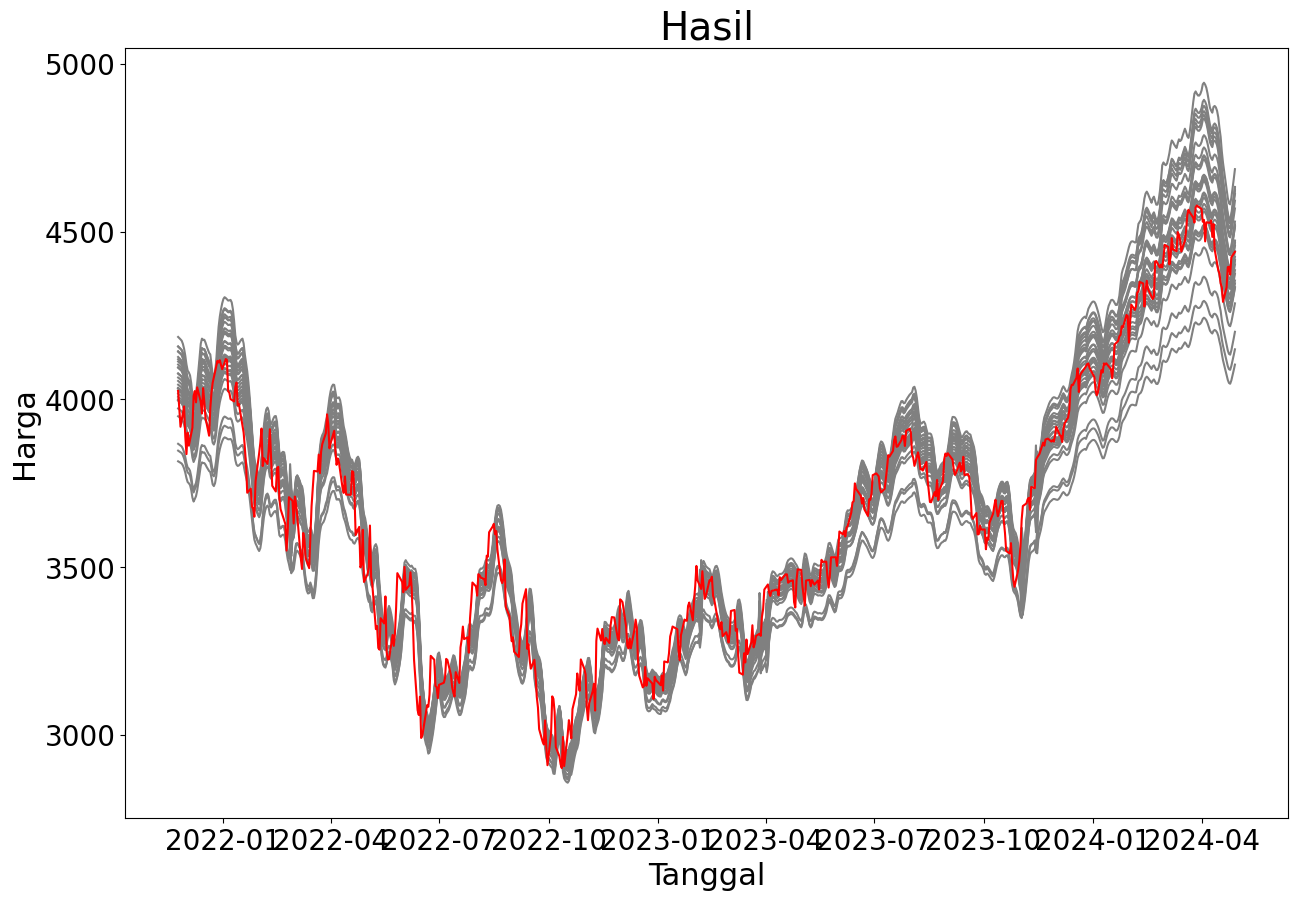

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

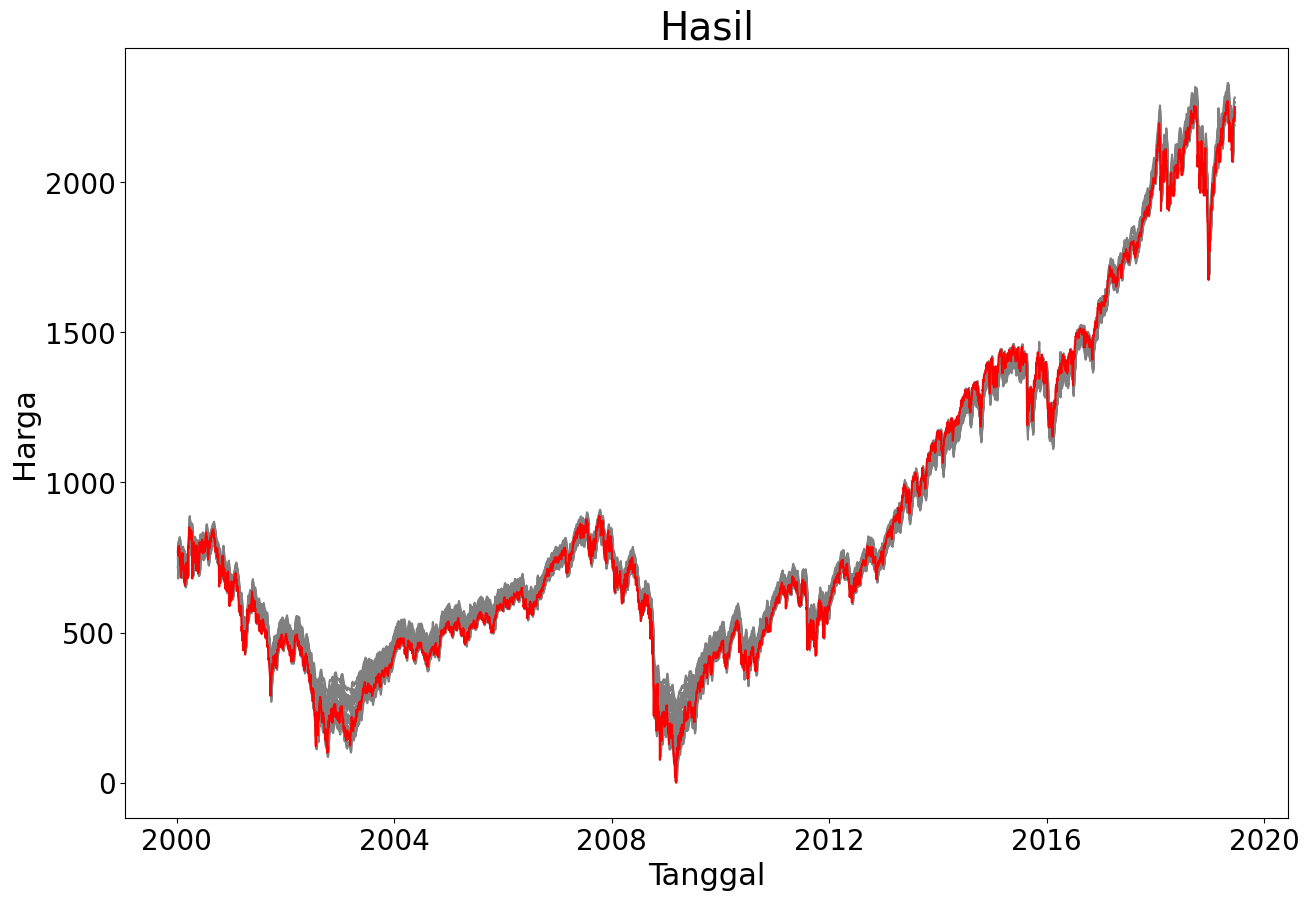

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## RNN dengan Bayesian

In [ ]:
from tensorflow.keras.layers import SimpleRNN
rnn = Sequential()
rnn.add(SimpleRNN(64, activation='relu', input_shape=(2, 2), return_sequences=False))
rnn.add(Dropout(0.3))
rnn.add(Dense(1))

rnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         4,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("rnnbo_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(rnn)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"rnnbo_weights/best_rnnbo_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")


 Model di iterasi ke-7 dengan MAPE = 0.0260


In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.885193   0.890307   0.898862   0.887199   0.894800   0.904550   
2021-11-25   0.884713   0.889892   0.898442   0.886692   0.894337   0.904110   
2021-11-26   0.883855   0.889006   0.897497   0.885835   0.893370   0.903155   
2021-11-27   0.883108   0.888281   0.896736   0.885073   0.892573   0.902377   
2021-11-28   0.881441   0.886679   0.895061   0.883368   0.890810   0.900661   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.967382   0.970956   0.984378   0.968892   0.983135   0.991077   
2024-04-26   0.970255   0.973571   0.987068   0.971882   0.986033   0.993865   
2024-04-27   0.975980   0.979165   0.993057   0.977539   0.992159   0.999822   
2024-04-28   0.981870   0.984897   0.999184   0.983377   0.998441   1.005946   
2024-04-29   0.988127   0.991039   1.005711   0.989570   1.005125   1.012468   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDO.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDO.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDO.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_INDO.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDO.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDO.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksirnnbo_INDO.csv')
bm_train_predictions.to_csv('hasilprediksirnnbo_train_INDO.csv')
bm_val_predictions.to_csv('hasilprediksirnnbo_val_INDO.csv')


In [ ]:
!zip -r rnnbo_weights.zip /content/rnnbo_weights
from google.colab import files
files.download("rnnbo_weights.zip")

  adding: content/rnnbo_weights/ (stored 0%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_4.weights.h5 (deflated 43%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_27.weights.h5 (deflated 40%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_7.weights.h5 (deflated 39%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_24.weights.h5 (deflated 41%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_29.weights.h5 (deflated 41%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_21.weights.h5 (deflated 42%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_30.weights.h5 (deflated 42%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_20.weights.h5 (deflated 38%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_3.weights.h5 (deflated 41%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_23.weights.h5 (deflated 40%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_25.weights.h5 (deflated 40%)
  adding: content/rnnbo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

29.823684329282916 1718.348780069977 41.45297070259232 85938688836419.17
53.214472911021396 5820.559661916607 76.29259244459195 0.020332680647485595
88.98345470714852 12730.745620048772 112.83060586582336 0.024049166026245777


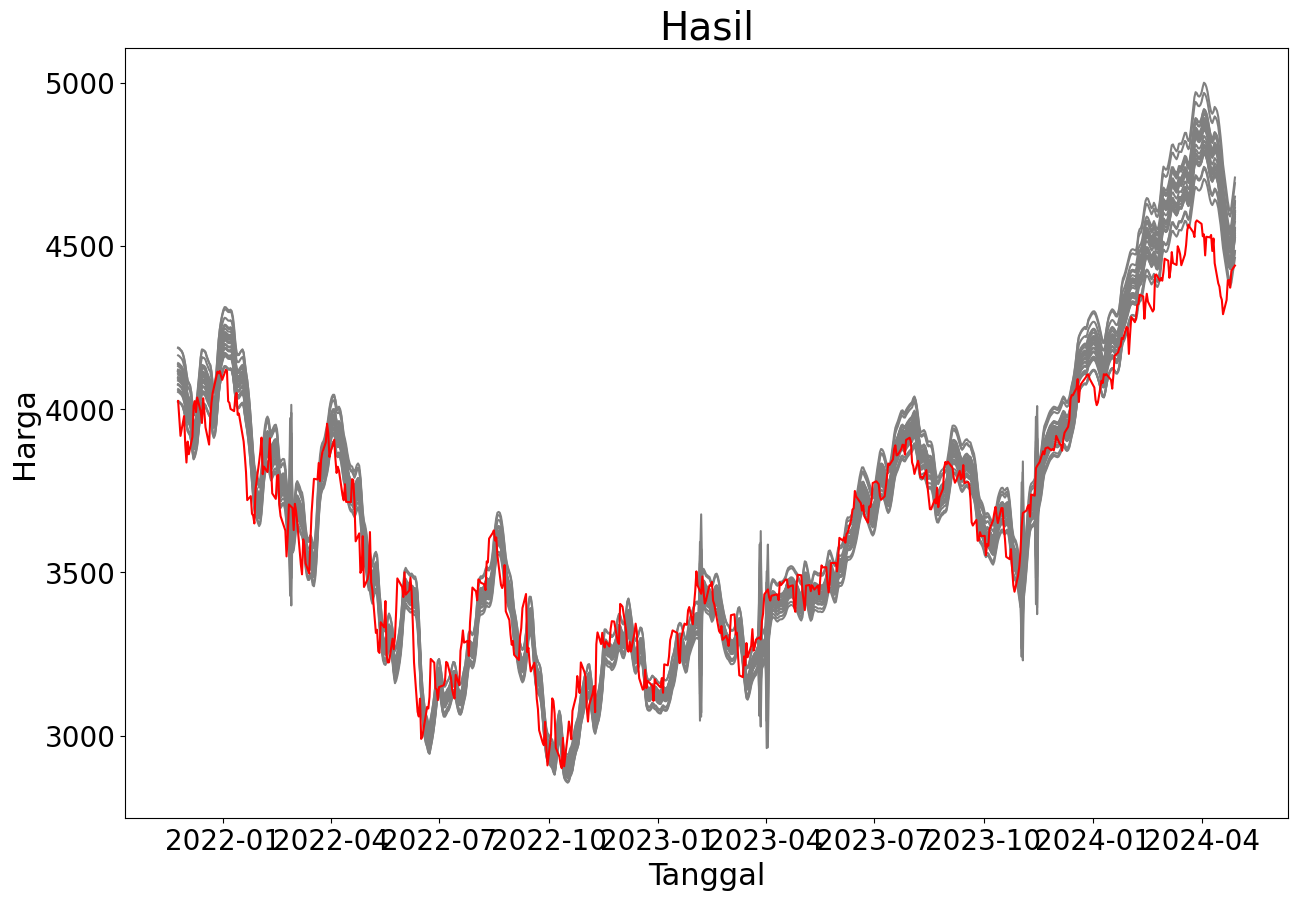

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

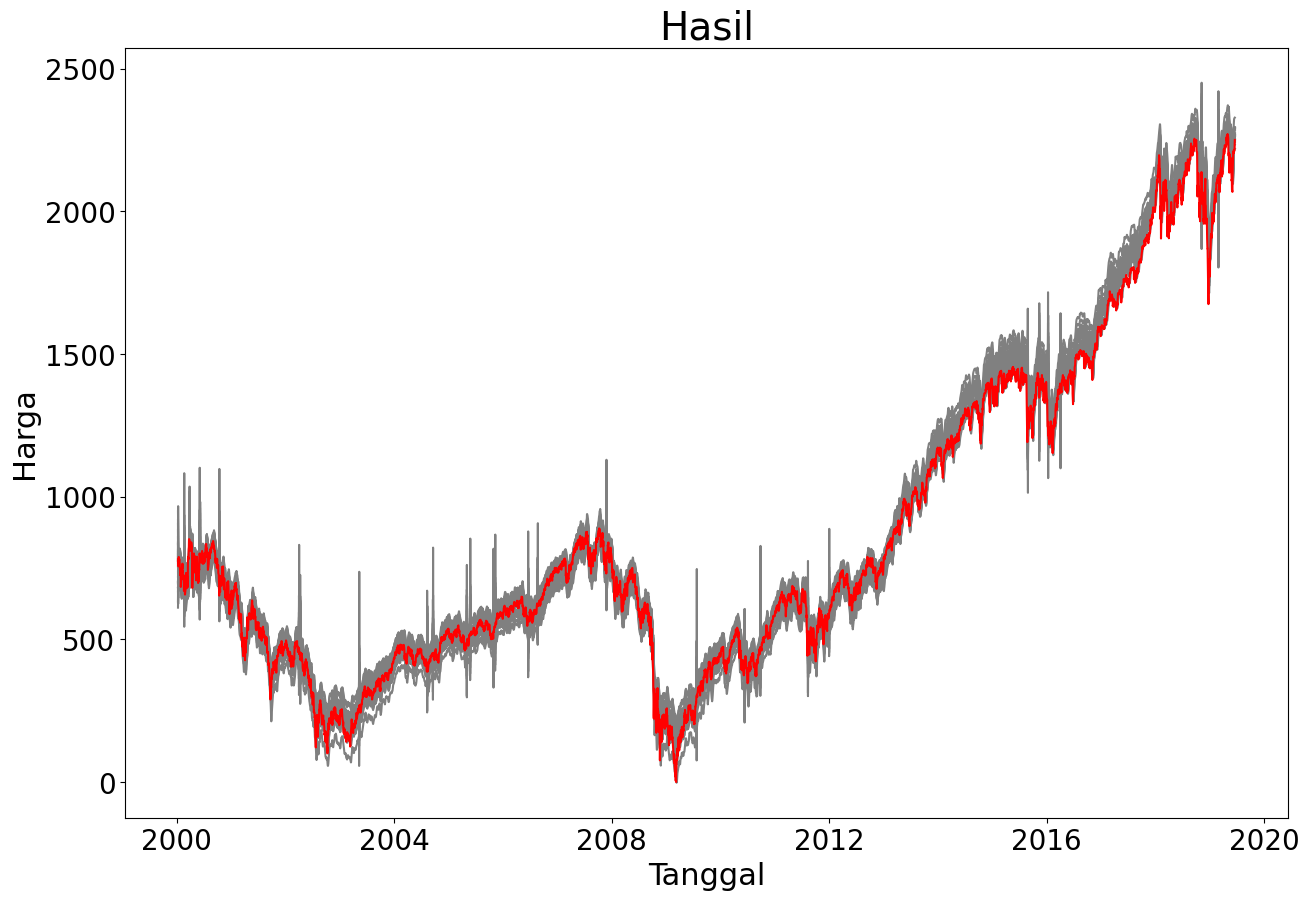

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## LSTM dengan Input Harga Saham dan Keputusan Jual Beli

In [ ]:
datacopy = data_full[3:]
datacopy

In [ ]:
datacopy['EMA_50'] = datacopy['Close'].ewm(span=50, adjust=False).mean()
datacopy['EMA_200'] = datacopy['Close'].ewm(span=200, adjust=False).mean()
datacopy['Diff']= datacopy['EMA_50']-datacopy['EMA_200']
datacopy['sign'] = datacopy['Diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
datacopy['sign_change'] = datacopy['sign'].diff().apply(lambda x: 1 if x != 0 else 0)
filter = datacopy[datacopy['sign_change'] == 1]
idx_datafull = filter.index
datacopy['label'] = np.where(
    (datacopy['sign'] == 1) & (datacopy['sign_change'] != 0), 'Sell',
    np.where((datacopy['sign'] == -1) & (datacopy['sign_change'] != 0), 'Buy', 'Keep')
)
check = datacopy[datacopy['sign_change'] != 0]
check

In [ ]:
datacopy['label1'] = datacopy['label'].apply(lambda x: -1 if x == 'Sell' else (1 if x == 'Buy' else 0))
datacopy
check = datacopy[datacopy['label1'] != 0]
check

In [ ]:
#data_full['Close'] = pd.to_numeric(datacopy['Close'])
#datacopy['label1'] = pd.to_numeric(datacopy['label1'])

X_actual, y_actual, dates_actual = windowed_df_close(datacopy[['Close','label1']],2)
banyakn = len(X_actual)
Mq_80 = int(banyakn * .8)
Mq_90 = int(banyakn * .9)
dates_actual_train, X_actual_train, y_actual_train = dates_actual[:Mq_80], X_actual[:Mq_80], y_actual[:Mq_80]
dates_actual_val, X_actual_val, y_actual_val = dates_actual[Mq_80:Mq_90], X_actual[Mq_80:Mq_90], y_actual[Mq_80:Mq_90]
dates_actual_test, X_actual_test, y_actual_test = dates_actual[Mq_90:], X_actual[Mq_90:], y_actual[Mq_90:]

In [ ]:
datacopy

In [ ]:
y_actual.shape

In [ ]:
from hyperopt import hp

space = {
    'hiddenLayerOne': hp.choice('hiddenLayerOne', [32, 64, 128]),
    'hiddenLayerTwo': hp.choice('hiddenLayerTwo', [32, 64, 128]),
    'activation': hp.choice('activation', ['tanh', 'relu']),
    'epochs': hp.choice('epochs',[50,100,150,200]),
    'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.01]),
    'dropout': hp.choice('dropout', [0.1, 0.2, 0.3]),
    'batch_size': hp.choice('batch_size', [32, 64, 128])
}

def objective(params):
    model = Sequential([
        LSTM(params['hiddenLayerOne'], activation=params['activation'], return_sequences=True, input_shape=(2, 2)),
        Dropout(params['dropout']),
        LSTM(params['hiddenLayerTwo'], activation=params['activation']),
        Dropout(params['dropout']),
        Dense(1, activation='linear')
    ])

    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                  loss='mse',
                  metrics=['mean_absolute_error'])

    es = EarlyStopping(monitor='val_loss',mode='min',
                       verbose=1,patience=5)

    model.fit(X_actual_train, y_actual_train, batch_size=int(params['batch_size']),validation_data=(X_actual_val, y_actual_val))

    score, acc = model.evaluate(X_actual_val, y_actual_val, verbose=0)

    return {'loss': -acc,
            'status': STATUS_OK,
            'model': model,
            'params': params}

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
trials = Trials()

In [ ]:
best_params = fmin(
  fn=objective,
  space=space,
  algo=tpe.suggest,
  max_evals=175,
  trials=trials)

In [ ]:
space_eval(space, best_params)

In [ ]:
LSTM_EMA_model = Sequential([
    layers.LSTM(32, activation = 'relu', return_sequences = True, input_shape = (2,2)),
    layers.Dropout(0.2),
    layers.LSTM(32,activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation = 'linear')
])

LSTM_EMA_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

LSTM_EMA_model.summary()

RUN

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta = 0.0001,
    restore_best_weights=True
)

In [ ]:
result = []
mapes = []
prediction_result = []
histories = []

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(LSTM_EMA_model)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss = 'mse',
        metrics = ['mean_absolute_error'],
    )

    history = model.fit(X_actual_train, y_actual_train, batch_size=128, validation_data=(X_actual_val, y_actual_val), epochs=50)

    result.append(history)
    histories.append(history.history)

    predictions = model.predict(X_actual_test).flatten()
    mape = mean_absolute_percentage_error(y_actual_test, predictions)
    prediction_result.append(predictions)
    mapes.append(mape)
    print(f"Iteration {i+1}: MAPE = {mape}")

In [ ]:
import numpy as np

all_train_loss = np.array([h['loss'] for h in histories])
all_val_loss = np.array([h['val_loss'] for h in histories])

mean_train_loss = np.mean(all_train_loss, axis=0)
mean_val_loss = np.mean(all_val_loss, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mean_train_loss, label='Rata-rata Training Loss')
plt.plot(mean_val_loss, label='Rata-rata Validation Loss')
plt.title('Rata-rata Loss per Epoch dari 30 Iterasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
prediction_df = pd.DataFrame(prediction_result).transpose()
prediction_df.index = dates_actual_test
prediction_df.columns = [f'Iterasi {i+1}' for i in range(prediction_df.shape[1])]
print(prediction_df)

In [ ]:
prediction_df2 = prediction_df.copy(deep=True)
print(prediction_df2)

In [ ]:
prediction_df2 = prediction_df2.multiply(range_value)
print(prediction_df2)

In [ ]:
y_test2 = y_actual_test * range_value
y_test2

In [ ]:
prediction_df2['Rata2'] = prediction_df2.mean(axis=1)
print(prediction_df2)

In [ ]:
from math import sqrt
hasil = prediction_df2['Rata2']
close_test_mae = mean_absolute_error(y_test2, hasil)
close_test_mse = mean_squared_error(y_test2, hasil)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test2, hasil)
close_test_mae, close_test_mse, close_test_rmse, close_test_mape

In [ ]:
prediction_df2.to_csv('hasilprediksilstm2fit_INDO.csv')